<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ridge_regression
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np
import copy

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (d, d) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (d * n, d)
        n, d = X.shape
        q = compute_q(p)

        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(d)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", n," ", d)
        print("y shape", y.shape)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", d*n)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        #if np.sum(S_mis * S_mis) == 0:
        if np.all(S_dict['S_mis'] == 0):
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        else:  # S_mis.shape == (n, d, d):
          S_dts_tiled = np.concatenate([S_dts] * n)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (d, d):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (d * n, d):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (n, d), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / n * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []

# dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}
def get_path(X, y, estimator, S_dict): #eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape

    if S_dict['algo_superv_learn'] == 'adv':
      n_a_dts = S_dict['n_a_dts']
      a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
      a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']
      if np.all(S_dict['S_mis'] == 0):
        n_a_mis, a_d_mis_max, a_d_mis_min = 1, 0, 0
      else:
        n_a_mis = S_dict['n_a_mis']
        a_d_mis_max = S_dict['adv_rad_times_delta_mis_max']
        a_d_mis_min = a_d_mis_max * S_dict['eps_adv_rad_times_delta_mis']


      if a_d_dts_max < 0 or a_d_mis_max < 0 or n_a_dts < 1 or n_a_mis <1:
        print("WARNING: some bad values for the grid of cross validation, the number of grid point should be strictly potive, the radius strictly positive")
      alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts) if a_d_dts_max > 0 else np.zeros(1)
      alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis) if a_d_mis_max > 0 else np.zeros(1)
      #alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts)
      #alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis)
      print("dts deltas ", alphas_dts)
      print("mis deltas ", alphas_mis)
      #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
      hyper_p_ret_ = []
      coefs_ = []
      for a_mis_value in tqdm.tqdm(alphas_mis):
        for a_dts_value in tqdm.tqdm(alphas_dts):
            #tuple_key = (scale_dts_value, scale_mis_value)
            #coefs_ = []
            #for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
              #print("dict hyper in get path ", dict_hyper_p_values)
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a_dts_value, a_mis_value])
            #res[tuple_key] = np.stack((coefs_)).T
    elif S_dict['algo_superv_learn'] == 'ridge':
      n_a_rid = S_dict['n_a_rid']
      a_rid_max = S_dict['alpha_ridge_reg_max']
      a_rid_min = a_rid_max * S_dict['eps_alpha_ridge_reg']
      alphas_rid = np.logspace(np.log10(a_rid_min), np.log10(a_rid_max), n_a_rid) if a_rid_max > 0 else np.zeros(1)
      print("rid alphas ", alphas_rid)
      hyper_p_ret_ = []
      coefs_ = []
      S_dts_inv = np.linalg.inv(S_dict['S_dts'])  # (d, d)
      print("S_dts_inv in get path, ridge regression \n", S_dts_inv)
      for a_rid in tqdm.tqdm(alphas_rid):
            #dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
            #print("dict hyper in get path ", dict_hyper_p_values)
            coefs = estimator(X @ S_dts_inv, y, a_rid)
            coefs = S_dts_inv @ coefs
            #print("alpha  ", a, "coef: ", coefs)
            coefs_.append(coefs if coefs is not None else np.zeros(m))
            hyper_p_ret_.append([a_rid, a_rid])  #([a_dts_value, a_mis_value])


    '''
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

#dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg': 1,
#                             'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'eps_alpha_ridge_reg': 1e-4,
#                             'n_a_dts': 25, 'n_a_mis':4, 'n_a_rid': 25}}





'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):

    if S_dict['algo_superv_learn'] == 'adv':
      linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
      estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
    elif S_dict['algo_superv_learn'] == 'ridge':
      estimator = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False)#, random_state=0)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
      #estimator = lambda X, y, a: linear_model.Ridge(alpha=a).fit(X, y).coef_
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf


X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)

alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=True, random_state=0)
for a in alphas:
  coef, intercept = estim(X, y, a)
  print("coef : ", coef)
  print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  print("coef : ", coef)
  print("intercpt ", intercept)


'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
coef :  [ 2.00954423e+00 -1.00900913e+00 -2.00208214e-03  1.12023152e-02]
intercpt  -0.009467645111085636
coef :  [ 2.00954423e+00 -1.00900913e+00 -2.00208214e-03  1.12023152e-02]
intercpt  -0.009467645111085636
coef :  [ 2.00952192e+00 -1.00900100e+00 -2.00144210e-03  1.12032169e-02]
intercpt  -0.009467082706545761
coef :  [ 2.00952192e+00 -1.00900100e+00 -2.00144210e-03  1.12032169e-02]
intercpt  -0.009467082706545761
coef :  [ 2.00717298e+00 -1.00820576e+00 -1.98787619e-03  1.12136026e-02]
intercpt  -0.00936677535969165
coef :  [ 2.00717298e+00 -1.00820576e+00 -1.98787619e-03  1.12136026e-02]
intercpt  -0.00936677535969165
coef :  [ 1.98729553e+00 -1.00093399e+00 -1.41618578e-03  1.20339444e-02]
intercpt  -0.008922028655146031
coef :  [ 1.98729553e+00 -1.00093399e+00 -1.41618578e-03  1.20339444e-02]
intercpt  -0.008922028655146031
end block


In [3]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [4]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
'''
def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks
'''

def generate_masks(dictio_data):#nbr_of_sample, dim, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    dim = len(dictio_data['beta_gt'][0])
    nbr_of_sample = dictio_data['n_train'][0]
    p_missing = dictio_data['p_miss'][0]
    print("p_missing in generate mask ", p_missing)
    if dim == 2:
      if len(p_missing) < 3:
        print("WARNING: p_missing should be a list with a length of 3 if the dimension is 2")
      masks = np.zeros((nbr_of_sample, 2))
      v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
      masks[v == 0, :] = np.array([0, 0])  # both seen
      masks[v == 1, :] = np.array([0, 1])  # left seen
      masks[v == 2, :] = np.array([1, 0])  # right seen
    else:
      # in this branch, p_missing = [p1,.., pl],
      masks = np.array([np.random.binomial(1, 1-pr, (nbr_of_sample, dim)) for pr in p_missing])
      masks = np.cumsum(masks, axis=0)  # each round
      masks[masks>1] = 1
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [5]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)  # size (info['mi_nbr], n, d)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        #s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = std_vectors[:, None, :] * np.eye(std_vectors.shape[-1])  # should be (m, d, d), with each diagonal the diagonals of std_vectors
        #S = s_within
        #S = np.diag(s_within)
        print("final S.shape in cov strategy std_mi ", S.shape)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure'] and 'cov_strategy_between' in info.keys():
      m, n, d = X_imputed.shape
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
        if info['post_imp'] == 'conc':
          S_mis = np.tile(S_mis, (m, 1, 1))
    else:  # not using a mi method, so uncertainty on missing part should be zero
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      print("shape X_imputed ", X_imputed.shape)
      X_train = np.concatenate(X_imputed)
      y_train = np.tile(y_train, X_imputed.shape[0])
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    # masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    # masks_train = generate_masks_binomial(n_train, p_miss)  # 1 missing, 0 observed
    #X_train, y_train, masks_train = clear_dataset(X_train, y_train, masks_train)
    # M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    # dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, []), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      print("NO PREVIOUS IMPUTATION HAS BEEN DONE")
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      print("A PREVIOUS IMPUTATION HAS BEEN DONE")
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) #* dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  #* dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    if 'post_imp' in dict_obs.keys():
      if dict_obs['post_imp'] == 'conc':
        print(S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing} | dict_obs['info_algo'] | {'algo_superv_learn': dict_imp['algo_superv_learn']}  # , 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    # dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}

    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi' and dict_imp['cov_strategy'] == 'std_mi':  # run a standard multiple imputation procedure
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      min_score = 0
      temporary_dictionary = copy.deepcopy(S_dict)
      for i in range(dict_imp['mi_nbr']):
        print("i  mi .-------------> ", i)
        #dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        #dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        #S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        #S = S_within[None, :, :] + S_between
        #S = np.concatenate(S, axis=0)
        #print(S)
        #alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        temporary_dictionary['S_dts'] = S_dict['S_dts'][i, :, :]
        print("temporary dict ", temporary_dictionary)
        hyper_p_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, temporary_dictionary, [])
        idx_best, min_score_partial = best_idx_predictor(X_test, coeff_results, y_test)
        print("weee ", idx_best)
        print(coeff_results.shape)
        print(hyper_p_used.shape)
        best_coeff_partial, _ = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        min_score += min_score_partial
        #best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
      best_coeff /= dict_imp['mi_nbr']
      min_score /=  dict_imp['mi_nbr']
      best_hyper_p = 0  # not important right now
      best_alpha_delta_dts = 1  # not important right now
      #best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha_delta_dts, best_alpha_delta_mis = best_hyper_p[0], best_hyper_p[1]
#      print("best alpha ----> ", best_alpha_dts)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = S_dict['S_dts'] * best_alpha_delta_dts + S_dict['S_mis'] * best_alpha_delta_mis
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])


    # obsere that one day you shoul add the return of alpha_delta_mis also
    return best_coeff, min_score, -np.log10(best_alpha_delta_dts)



In [6]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])  # how many trials shall we do
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed  = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][0],
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][0],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0]
                                             )  # return {'X_train_masked':(X_train, mask_train) , 'X_test':.., 'y_train':, 'y_test'}
      #mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen
      full_masks = generate_masks(dictio)
    dictio_obser_fixed_copy = copy.deepcopy(dictio_obser_fixed)

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        if len(dictio['beta_gt'][0]) == 2:
          #mask_partial = dict_obser_partial['X_train_masked'][1]
          p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
          n_train = full_masks.shape[0]
          mask_partial = full_masks.copy()
          mask_partial[0:int(n_train * p_i), :] = 0
          tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
          dict_obser['X_train_masked'] = tuple_partial
        else:
          #print("size in run experiment", dictio_obser_fixed_copy['X_train_masked'][0].shape, "wee ", dictio_obser_fixed['y_train'].shape)
          ## we use the next line of code with dictio_obser_fixed_copy because we need to test the mask with the original dataset, otherwise we get size error (the dataset change if an observation get fully hidden)
          X_train_cleaned, y_train_cleaned, masks_train_cleaned = clear_dataset(dictio_obser_fixed_copy['X_train_masked'][0], dictio_obser_fixed_copy['y_train'], full_masks[i])
          #tuple_partial = (dictio_obser_fixed['X_train_masked'][0], full_masks[i])
          print("full masks in run experiment ", full_masks[i])
          dict_obser['X_train_masked'] = (X_train_cleaned, masks_train_cleaned)
          dict_obser['y_train'] = y_train_cleaned
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      print("info algo in run experiments ", dictio['info_algo'])
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}} | {'info_algo': dictio['info_algo']}  # add an entry for imputed dataset, and info for algorithm
      print("ciaoooooo dict obser in run experiments \n ", dict_obser)
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'])
  ax_res[1].set_title(extra_info['title_test_error'])
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  #rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  '''
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])
  '''
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




[ 0.49454236  0.40481745 -1.26208674 -0.8925156   0.37891237]
change nbr_experiments to match the size of n_train
data :  [{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}, {'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}, {'data': 'Norma

100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00464159 0.        ] , min score  3.0170738159958406
---------------------------------> best coeff  [ 0.50902164  0.51270908 -1.18792929 -0.85175814  0.217096  ]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.66799296 3.81885469 2.61985064 4.78668331 3.1745426 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -107.40511266642503
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00464159 0.        ] , min score  3.0170738159958415
---------------------------------> best coeff  [ 0.50902164  0.51270908 -1.18792929 -0.85175814  0.217096  ]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.66799296 3.81885469 2.61985064 4.78668331 3.1745426 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -107.40511266642503
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[6.66799296 0.         0.         0.         0.      

100%|██████████| 40/40 [00:00<00:00, 1417.70it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.11937766] , min score  3.016923770558065
---------------------------------> best coeff  [ 0.5054345   0.51216936 -1.19954037 -0.8454384   0.22434352]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.66799296 3.81885469 2.61985064 4.78668331 3.1745426 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -107.40511266642503
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1261.46it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.11937766] , min score  3.016923770558066
---------------------------------> best coeff  [ 0.5054345   0.51216936 -1.19954037 -0.8454384   0.22434352]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -109.97024713309793
[0 0 1 1 1 0 1 0 0 0 0 1 2 1 1 0 0 1 0 0 0 0 1 0 0 0 2 0 0 1 1 0 0 0 0 2 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0
 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0]
S dataset 
 [[6.74972667 0.         0.         0.         0.        ]
 [0.         3.86068294 0.         0.         0.        ]
 [0.         0.         2.67882834 0.         0.        ]
 [0.         0.         0.         4.85929562 0.        ]
 [0.         0.         0.         0.         3.20776798]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  63  nbr_miss :  37
X  100   5
y shape (100,)
nm  500
S_mis in Adb

100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.088597793861659
---------------------------------> best coeff  [ 0.45427845  0.47870853 -1.3835252  -0.7300129   0.3507305 ]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.66799296 3.81885469 2.61985064 4.78668331 3.1745426 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -107.40511266642503
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00464159 0.        ] , min score  3.0170738159958415
---------------------------------> best coeff  [ 0.50902164  0.51270908 -1.18792929 -0.85175814  0.217096  ]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.66799296 3.81885469 2.61985064 4.78668331 3.1745426 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -109.97024713309793
[0 0 1 1 1 0 1 0 0 0 0 1 2 1 1 0 0 1 0 0 0 0 1 0 0 0 2 0 0 1 1 0 0 0 0 2 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0
 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0]
S dataset 
 [[6.74972667 0.         0.         0.         0.      

100%|██████████| 40/40 [00:00<00:00, 1222.75it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.0885132546341425
---------------------------------> best coeff  [ 0.45452356  0.47885177 -1.38296266 -0.73039586  0.35030974]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.66799296 3.81885469 2.61985064 4.78668331 3.1745426 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -107.40511266642503
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 1141.11it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.11937766] , min score  3.016923770558066
---------------------------------> best coeff  [ 0.5054345   0.51216936 -1.19954037 -0.8454384   0.22434352]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 0 0]
 [0 1 0 0 1

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -110.07440541604834
[1 0 2 2 2 0 1 0 0 1 0 1 3 1 2 0 0 3 0 0 0 0 1 0 0 2 2 2 2 3 1 1 2 0 0 2 1
 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 3 2 2 0 1 2 1 1 1 1 1 0 0 2 1 1
 1 1 0 0 1 1 1 1 1 0 0 1 2 1 1 0 0 0 1 1 2 1 1 1 0 1]
S dataset 
 [[6.98931597 0.         0.         0.         0.        ]
 [0.         3.82352362 0.         0.         0.        ]
 [0.         0.         2.75195373 0.         0.        ]
 [0.         0.         0.         5.02504959 0.        ]
 [0.         0.         0.         0.         3.13583796]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  36  nbr_miss :  64
X  100   5
y shape (100,)
nm  500
S_mis in Adb

100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.2462710549183385
---------------------------------> best coeff  [ 0.32247338  0.39228966 -1.69503583 -0.51933088  0.59649365]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.66799296 3.81885469 2.61985064 4.78668331 3.1745426 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -107.40511266642503
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00464159 0.        ] , min score  3.0170738159958415
---------------------------------> best coeff  [ 0.50902164  0.51270908 -1.18792929 -0.85175814  0.217096  ]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.66799296 3.81885469 2.61985064 4.78668331 3.1745426 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -110.07440541604834
[1 0 2 2 2 0 1 0 0 1 0 1 3 1 2 0 0 3 0 0 0 0 1 0 0 2 2 2 2 3 1 1 2 0 0 2 1
 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 3 2 2 0 1 2 1 1 1 1 1 0 0 2 1 1
 1 1 0 0 1 1 1 1 1 0 0 1 2 1 1 0 0 0 1 1 2 1 1 1 0 1]
S dataset 
 [[6.98931597 0.         0.         0.         0.      

100%|██████████| 40/40 [00:00<00:00, 1242.45it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.03665241] , min score  3.2453634101795235
---------------------------------> best coeff  [ 0.32399619  0.39388968 -1.68955183 -0.52176081  0.59225084]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.66799296 3.81885469 2.61985064 4.78668331 3.1745426 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -107.40511266642503
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 776.97it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.11937766] , min score  3.016923770558066
---------------------------------> best coeff  [ 0.5054345   0.51216936 -1.19954037 -0.8454384   0.22434352]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 0 0]
 [0 1 0 0 1

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -120.01419256422622
[1 0 2 2 2 0 1 1 0 1 0 1 3 2 3 0 1 4 3 0 1 0 2 0 0 2 3 3 2 3 1 4 3 1 1 2 2
 0 1 1 1 0 1 1 0 2 0 1 0 1 1 0 2 0 1 0 1 2 3 2 2 0 2 2 1 3 1 1 1 0 1 2 1 1
 1 1 2 0 1 1 2 1 2 1 1 2 2 2 2 1 0 1 1 1 2 2 2 1 0 1]
S dataset 
 [[6.56825439 0.         0.         0.         0.        ]
 [0.         3.93215543 0.         0.         0.        ]
 [0.         0.         2.806337   0.         0.        ]
 [0.         0.         0.         4.9595454  0.        ]
 [0.         0.         0.         0.         3.1645315 ]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  22  nbr_miss :  78
X  100   5
y shape (100,)
nm  500
S_mis in Adb

100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.324620294306644
---------------------------------> best coeff  [ 0.37984532  0.43731293 -1.54274815 -0.57889337  0.4677604 ]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.66799296 3.81885469 2.61985064 4.78668331 3.1745426 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -107.40511266642503
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00464159 0.        ] , min score  3.0170738159958415
---------------------------------> best coeff  [ 0.50902164  0.51270908 -1.18792929 -0.85175814  0.217096  ]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.66799296 3.81885469 2.61985064 4.78668331 3.1745426 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -120.01419256422622
[1 0 2 2 2 0 1 1 0 1 0 1 3 2 3 0 1 4 3 0 1 0 2 0 0 2 3 3 2 3 1 4 3 1 1 2 2
 0 1 1 1 0 1 1 0 2 0 1 0 1 1 0 2 0 1 0 1 2 3 2 2 0 2 2 1 3 1 1 1 0 1 2 1 1
 1 1 2 0 1 1 2 1 2 1 1 2 2 2 2 1 0 1 1 1 2 2 2 1 0 1]
S dataset 
 [[6.56825439 0.         0.         0.         0.      

100%|██████████| 40/40 [00:00<00:00, 1094.61it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.3242471695707936
---------------------------------> best coeff  [ 0.38030865  0.43758595 -1.54162446 -0.57956851  0.46697452]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.66799296 3.81885469 2.61985064 4.78668331 3.1745426 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -107.40511266642503
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 499.25it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.11937766] , min score  3.016923770558066
---------------------------------> best coeff  [ 0.5054345   0.51216936 -1.19954037 -0.8454384   0.22434352]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 1 0 0]
 [0 0 0 1 0]
 [0 1 1 0 0]
 [0 1 1 0 1

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  2  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00018047 0.        ] , min score  4.833357460196902
---------------------------------> best coeff  [ 4.76203099e-02  2.39520082e-01 -2.47462230e+00  5.34435468e-05
  9.85905522e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.67106682 3.76282908 2.63384591 4.83637335 3.14520977]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -132.8469493462878
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  3.0435484406483995
---------------------------------> best coeff  [ 0.51694582  0.49705012 -1.18515902 -0.85863777  0.20125799]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.67106682 3.76282908 2.63384591 4.83637335 3.14520977]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -110.85098060292509
[2 1 2 3 2 2 1 1 1 3 0 2 3 2 4 0 1 4 0 2 1 2 1 1 2 3 3 2 3 3 3 1 3 2 3 0 2
 1 1 2 2 2 1 3 0 1 0 1 1 2 2 0 1 0 1 3 3 2 2 2 2 2 2 4 1 1 1 1 1 2 1 2 1 2
 0 1 2 3 1 2 2 1 3 3 2 2 3 2 1 1 1 2 2 2 1 1 1]
S dataset 
 [[6.40485176 0.         0.         0.         0.        ]
 [

100%|██████████| 40/40 [00:00<00:00, 684.10it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.94266846 0.94266846] , min score  3.8319182546928947
---------------------------------> best coeff  [ 0.32571125  0.51415022 -1.57726066 -0.46899831  0.38257051]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.67106682 3.76282908 2.63384591 4.83637335 3.14520977]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -132.8469493462878
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 749.39it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  3.0414001437820506
---------------------------------> best coeff  [ 0.5060829   0.49459081 -1.22247363 -0.83855136  0.22600368]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 1 0 0]
 [0 0 0 1 0]
 [0 1 1 1 0]
 [0 1 1 0 

100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  5  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00043755 0.        ] , min score  5.200946862717392
---------------------------------> best coeff  [ 8.67838620e-02 -3.63627787e-08 -2.16463499e+00 -3.32978542e-01
  8.96183308e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.63424653 3.77755296 2.64626509 4.81212739 3.15306874]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -142.8174726808961
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  3.047997188587735
---------------------------------> best coeff  [ 0.52254225  0.50029853 -1.17569831 -0.86561256  0.19332189]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.63424653 3.77755296 2.64626509 4.81212739 3.15306874]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -221.77582165992908
[2 1 3 3 2 3 2 2 4 3 1 2 3 2 4 1 1 1 2 3 2 2 1 2 3 3 3 4 3 3 2 3 2 3 1 3 1
 1 2 3 2 2 3 2 3 4 3 1 3 3 1 1 3 1 3 3 2 2 3 3 3 2 4 1 1 2 1 2 2 1 3 2 2 1
 1 2 3 3 2 3 2 4 4 3 3 4 3 2 1 3 2 2 2 1 2 2]
S dataset 
 [[6.89312078 0.         0.         0.         0.        ]
 [0. 

100%|██████████| 40/40 [00:00<00:00, 996.94it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.04923883] , min score  4.969715264316809
---------------------------------> best coeff  [ 0.22176055  0.17456752 -1.81218073 -0.50989331  0.47520144]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.63424653 3.77755296 2.64626509 4.81212739 3.15306874]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -142.8174726808961
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 688.14it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  3.044055911204206
---------------------------------> best coeff  [ 0.50689508  0.49493887 -1.22111596 -0.83899424  0.22452715]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 0.50902164,  0.51270908, -1.18792929, -0.85175814,  0.217096  ]), array([ 0.45427845,  0.47870853, -1.3835252 , -0.7300129 ,  0.3507305 ]), array([ 0.32247338,  0.39228966, -1.69503583, -0.51933088,  0.59649365]), array([ 0.37984532,  0.43731293, -1.54274815, -0.57889337,  0.4677604 ]), array([ 4.76203099e-02,  2.39520082e-01, -2.47462230e+00,  5.34435468e-05,
        9.85905522e-01]), array([ 8.67838620e-02, -3.63627787e-08, -2.16463499e+00, -3.32978542e-01,
        8.96

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  3.1266616558422684
---------------------------------> best coeff  [ 0.50584352  0.36692011 -1.32292845 -0.86423932  0.34432586]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.47427474 3.49358097 2.86404869 4.35552819 2.94132737]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  38.62606369289203
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  3.1266616558422666
---------------------------------> best coeff  [ 0.50584352  0.36692011 -1.32292845 -0.86423932  0.34432586]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.47427474 3.49358097 2.86404869 4.35552819 2.94132737]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  38.62606369289203
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[6.47427474 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 1265.95it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  3.132609487528215
---------------------------------> best coeff  [ 0.49311478  0.35110322 -1.37227514 -0.8372145   0.38956373]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.47427474 3.49358097 2.86404869 4.35552819 2.94132737]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  38.62606369289203
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 1332.03it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  3.1326094875282124
---------------------------------> best coeff  [ 0.49311478  0.35110322 -1.37227514 -0.8372145   0.38956373]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  29.17839022474022
[0 0 1 1 0 0 0 0 0 0 0 0 1 1 2 0 1 0 2 1 1 0 2 0 1 1 0 1 1 0 0 1 0 0 0 2 0
 0 0 1 0 1 1 1 0 1 1 3 1 0 0 1 1 0 1 1 0 1 1 1 0 1 2 1 0 1 0 1 2 2 1 0 1 2
 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0]
S dataset 
 [[6.63348621 0.         0.         0.         0.        ]
 [0.         3.54826753 0.         0.         0.        ]
 [0.         0.         2.78183868 0.         0.        ]
 [0.         0.         0.         4.50938981 0.        ]
 [0.         0.         0.         0.         2.953674  ]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  48  nbr_miss :  52
X  100   5
y shape (100,)
nm  500
S_mis in Adbvt

100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.1086835016263796
---------------------------------> best coeff  [ 0.60745318  0.47499618 -0.91814227 -1.06041952  0.06825186]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.47427474 3.49358097 2.86404869 4.35552819 2.94132737]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  38.62606369289203
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  3.1266616558422666
---------------------------------> best coeff  [ 0.50584352  0.36692011 -1.32292845 -0.86423932  0.34432586]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.47427474 3.49358097 2.86404869 4.35552819 2.94132737]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  29.17839022474022
[0 0 1 1 0 0 0 0 0 0 0 0 1 1 2 0 1 0 2 1 1 0 2 0 1 1 0 1 1 0 0 1 0 0 0 2 0
 0 0 1 0 1 1 1 0 1 1 3 1 0 0 1 1 0 1 1 0 1 1 1 0 1 2 1 0 1 0 1 2 2 1 0 1 2
 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0]
S dataset 
 [[6.63348621 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 1085.52it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.94266846 0.94266846] , min score  3.0501339404695367
---------------------------------> best coeff  [ 0.52498469  0.42122856 -1.15767632 -0.92702716  0.23540114]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.47427474 3.49358097 2.86404869 4.35552819 2.94132737]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  38.62606369289203
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 1137.54it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  3.1326094875282124
---------------------------------> best coeff  [ 0.49311478  0.35110322 -1.37227514 -0.8372145   0.38956373]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [1 0 1 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -10.253464891141693
[1 1 1 2 0 1 1 0 1 1 1 0 3 1 3 1 1 1 2 1 2 0 2 1 1 2 0 2 2 1 1 1 0 2 0 2 1
 0 1 1 0 2 2 1 0 1 2 4 1 1 0 2 1 0 1 1 0 1 2 1 0 1 2 1 0 2 0 2 2 2 1 1 1 3
 2 0 4 1 0 1 3 1 2 1 0 0 1 1 0 1 2 1 0 0 1 1 0 1 0 0]
S dataset 
 [[6.36981731 0.         0.         0.         0.        ]
 [0.         3.40680464 0.         0.         0.        ]
 [0.         0.         2.66022285 0.         0.        ]
 [0.         0.         0.         4.4303479  0.        ]
 [0.         0.         0.         0.         2.94769911]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  26  nbr_miss :  74
X  100   5
y shape (100,)
nm  500
S_mis in Adb

100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.452992865343712
---------------------------------> best coeff  [ 0.54056204  0.48284165 -1.03859715 -0.93238862  0.00819175]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.47427474 3.49358097 2.86404869 4.35552819 2.94132737]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  38.62606369289203
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  3.1266616558422666
---------------------------------> best coeff  [ 0.50584352  0.36692011 -1.32292845 -0.86423932  0.34432586]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.47427474 3.49358097 2.86404869 4.35552819 2.94132737]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -10.253464891141693
[1 1 1 2 0 1 1 0 1 1 1 0 3 1 3 1 1 1 2 1 2 0 2 1 1 2 0 2 2 1 1 1 0 2 0 2 1
 0 1 1 0 2 2 1 0 1 2 4 1 1 0 2 1 0 1 1 0 1 2 1 0 1 2 1 0 2 0 2 2 2 1 1 1 3
 2 0 4 1 0 1 3 1 2 1 0 0 1 1 0 1 2 1 0 0 1 1 0 1 0 0]
S dataset 
 [[6.36981731 0.         0.         0.         0.      

100%|██████████| 40/40 [00:00<00:00, 1064.87it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.28942661 0.28942661] , min score  3.42834571968149
---------------------------------> best coeff  [ 0.49610813  0.45549179 -1.17888483 -0.8591898   0.10243521]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.47427474 3.49358097 2.86404869 4.35552819 2.94132737]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  38.62606369289203
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1174.51it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  3.1326094875282124
---------------------------------> best coeff  [ 0.49311478  0.35110322 -1.37227514 -0.8372145   0.38956373]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 1 1 0 0]
 [1 0 0 1 0]
 [0 0 1 1 0]
 [1 0 1 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -0.34664951429519775
[3 2 2 2 0 2 1 0 1 1 2 1 3 2 3 2 2 1 2 3 2 2 3 1 2 3 0 3 2 1 3 2 0 3 2 2 2
 2 1 1 2 2 2 1 1 1 3 4 2 1 1 4 2 1 2 1 1 1 2 1 0 1 2 2 0 3 0 3 2 4 1 1 1 3
 3 1 4 2 0 2 3 2 2 1 2 1 1 1 0 2 2 2 1 1 1 2 0 1 2 1]
S dataset 
 [[6.25768973 0.         0.         0.         0.        ]
 [0.         3.40782508 0.         0.         0.        ]
 [0.         0.         2.55232132 0.         0.        ]
 [0.         0.         0.         4.46653387 0.        ]
 [0.         0.         0.         0.         2.83766587]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  10  nbr_miss :  90
X  100   5
y shape (100,)
nm  500
S_mis in Ad

100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  5.8691543308731795
---------------------------------> best coeff  [ 0.41805366  0.28985409 -1.21627411 -0.79824846 -0.03853583]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.47427474 3.49358097 2.86404869 4.35552819 2.94132737]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  38.62606369289203
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  3.1266616558422666
---------------------------------> best coeff  [ 0.50584352  0.36692011 -1.32292845 -0.86423932  0.34432586]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.47427474 3.49358097 2.86404869 4.35552819 2.94132737]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.34664951429519775
[3 2 2 2 0 2 1 0 1 1 2 1 3 2 3 2 2 1 2 3 2 2 3 1 2 3 0 3 2 1 3 2 0 3 2 2 2
 2 1 1 2 2 2 1 1 1 3 4 2 1 1 4 2 1 2 1 1 1 2 1 0 1 2 2 0 3 0 3 2 4 1 1 1 3
 3 1 4 2 0 2 3 2 2 1 2 1 1 1 0 2 2 2 1 1 1 2 0 1 2 1]
S dataset 
 [[6.25768973 0.         0.         0.         0.     

100%|██████████| 40/40 [00:00<00:00, 1102.64it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  5.851391729806938
---------------------------------> best coeff  [ 0.42511053  0.29847598 -1.1864896  -0.81010389 -0.05774985]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.47427474 3.49358097 2.86404869 4.35552819 2.94132737]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  38.62606369289203
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 677.25it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  3.1326094875282124
---------------------------------> best coeff  [ 0.49311478  0.35110322 -1.37227514 -0.8372145   0.38956373]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 1 1 0 0]
 [1 0 1 1 0]
 [0 0 1 1 0]
 [1 0 1 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  6.673831501224129
[3 3 2 3 0 2 1 1 2 1 2 1 3 4 3 3 2 1 2 3 3 3 3 1 3 3 2 3 2 1 3 4 0 2 3 2 3
 1 2 2 2 2 2 2 2 3 4 2 2 1 4 2 1 3 2 1 2 2 1 0 1 3 2 0 4 0 3 3 4 1 1 1 3 3
 1 4 3 2 2 4 2 3 1 3 1 1 2 1 2 2 3 2 2 2 2 0 2 2 1]
S dataset 
 [[6.00623628 0.         0.         0.         0.        ]
 [0.         3.39260364 0.         0.         0.        ]
 [0.         0.         2.63778184 0.         0.        ]
 [0.         0.         0.         4.56957444 0.        ]
 [0.         0.         0.         0.         2.85596484]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (99, 5)
y_train length  99
-------> size test:  20000  , size train:  99 nbr_seen (train):  6  nbr_miss :  93
X  99   5
y shape (99,)
nm  495
S_mis in Adbvt trainin

100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00464159 0.        ] , min score  6.05163646396663
---------------------------------> best coeff  [ 1.90359405e-01 -1.10739140e-08 -2.16821050e+00 -1.97773530e-01
  9.12579529e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.50400469 3.46521898 2.85241601 4.36362166 2.90800326]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  58.294893329256155
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  3.09217263901323
---------------------------------> best coeff  [ 0.50464734  0.38558953 -1.30119279 -0.8598728   0.33285225]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.50400469 3.46521898 2.85241601 4.36362166 2.90800326]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  6.673831501224129
[3 3 2 3 0 2 1 1 2 1 2 1 3 4 3 3 2 1 2 3 3 3 3 1 3 3 2 3 2 1 3 4 0 2 3 2 3
 1 2 2 2 2 2 2 2 3 4 2 2 1 4 2 1 3 2 1 2 2 1 0 1 3 2 0 4 0 3 3 4 1 1 1 3 3
 1 4 3 2 2 4 2 3 1 3 1 1 2 1 2 2 3 2 2 2 2 0 2 2 1]
S dataset 
 [[6.00623628 0.         0.         0.         0.        ]
 [

100%|██████████| 40/40 [00:00<00:00, 1325.24it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.94266846 0.94266846] , min score  5.410032761760073
---------------------------------> best coeff  [ 0.38931876  0.221381   -1.49414632 -0.50860945  0.42792106]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.50400469 3.46521898 2.85241601 4.36362166 2.90800326]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  58.294893329256155
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 952.76it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  3.1095819268448537
---------------------------------> best coeff  [ 0.49486534  0.36285006 -1.36664286 -0.83135693  0.39517028]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 1 1 1 0]
 [1 1 1 1 0]
 [0 1 1 1 0]
 [1 0 1 1 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -85.52325697406981
[4 4 3 4 1 2 1 1 3 2 3 3 3 4 3 3 3 2 2 4 3 4 3 3 3 4 3 3 2 2 3 4 0 3 3 2 3
 2 3 3 2 3 2 3 4 3 4 4 3 2 4 2 1 3 2 1 3 2 3 2 2 4 2 0 4 1 3 4 4 1 2 1 3 3
 1 4 3 2 3 4 2 3 2 3 1 3 2 1 2 2 3 2 4 2 2 0 2 2 2]
S dataset 
 [[6.03216816 0.         0.         0.         0.        ]
 [0.         3.45810866 0.         0.         0.        ]
 [0.         0.         2.60437157 0.         0.        ]
 [0.         0.         0.         4.45663926 0.        ]
 [0.         0.         0.         0.         2.93550013]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (99, 5)
y_train length  99
-------> size test:  20000  , size train:  99 nbr_seen (train):  3  nbr_miss :  96
X  99   5
y shape (99,)
nm  495
S_mis in Adbvt traini

100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  8.387459456147209
---------------------------------> best coeff  [ 1.14337088e-01  1.80018520e-01 -2.23610812e+00  6.11726368e-10
  6.21012095e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.50400469 3.46521898 2.85241601 4.36362166 2.90800326]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  58.294893329256155
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  3.09217263901323
---------------------------------> best coeff  [ 0.50464734  0.38558953 -1.30119279 -0.8598728   0.33285225]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.50400469 3.46521898 2.85241601 4.36362166 2.90800326]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -85.52325697406981
[4 4 3 4 1 2 1 1 3 2 3 3 3 4 3 3 3 2 2 4 3 4 3 3 3 4 3 3 2 2 3 4 0 3 3 2 3
 2 3 3 2 3 2 3 4 3 4 4 3 2 4 2 1 3 2 1 3 2 3 2 2 4 2 0 4 1 3 4 4 1 2 1 3 3
 1 4 3 2 3 4 2 3 2 3 1 3 2 1 2 2 3 2 4 2 2 0 2 2 2]
S dataset 
 [[6.03216816 0.         0.         0.         0.        ]
 

100%|██████████| 40/40 [00:00<00:00, 590.76it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  8.302127254895957
---------------------------------> best coeff  [ 0.22048706  0.14482634 -1.87153539 -0.1789102   0.5126119 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.50400469 3.46521898 2.85241601 4.36362166 2.90800326]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  58.294893329256155
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 1177.67it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  3.1095819268448537
---------------------------------> best coeff  [ 0.49486534  0.36285006 -1.36664286 -0.83135693  0.39517028]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 0.50584352,  0.36692011, -1.32292845, -0.86423932,  0.34432586]), array([ 0.60745318,  0.47499618, -0.91814227, -1.06041952,  0.06825186]), array([ 0.54056204,  0.48284165, -1.03859715, -0.93238862,  0.00819175]), array([ 0.41805366,  0.28985409, -1.21627411, -0.79824846, -0.03853583]), array([ 1.90359405e-01, -1.10739140e-08, -2.16821050e+00, -1.97773530e-01,
        9.12579529e-01]), array([ 1.14337088e-01,  1.80018520e-01, -2.23610812e+00,  6.11726368e-10,
        6.2

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  3.1708270017981737
---------------------------------> best coeff  [ 0.35164097  0.28416798 -1.67603758 -0.63598777  0.79863561]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.518717319936364
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  3.170827001798157
---------------------------------> best coeff  [ 0.35164097  0.28416798 -1.67603758 -0.63598777  0.79863561]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.518717319936364
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[6.91546567 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 1009.39it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  3.1601452780952113
---------------------------------> best coeff  [ 0.37379958  0.29805522 -1.60177851 -0.66579395  0.75370933]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.518717319936364
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 791.10it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  3.16014527809521
---------------------------------> best coeff  [ 0.37379958  0.29805522 -1.60177851 -0.66579395  0.75370933]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]

100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  3.1247701186788692
---------------------------------> best coeff  [ 0.38292398  0.30111697 -1.58144678 -0.69682974  0.73395116]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.518717319936364
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  3.170827001798157
---------------------------------> best coeff  [ 0.35164097  0.28416798 -1.67603758 -0.63598777  0.79863561]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  32.0651563761826
[1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 2 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0]
S dataset 
 [[7.08106197 0.         0.         0.         0.        ]


100%|██████████| 40/40 [00:00<00:00, 723.59it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  30  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.70170383 0.70170383] , min score  3.1230140707620246
---------------------------------> best coeff  [ 0.38314007  0.30817209 -1.56824775 -0.69691804  0.71984889]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.518717319936364
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1241.60it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  3.16014527809521
---------------------------------> best coeff  [ 0.37379958  0.29805522 -1.60177851 -0.66579395  0.75370933]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  31.850013338973366
[1 1 1 1 0 1 2 0 0 1 2 0 0 0 1 1 1 0 2 2 1 1 1 0 1 2 1 0 2 2 0 1 1 1 0 1 0
 2 1 1 2 1 0 0 1 1 1 1 2 1 0 0 0 1 0 2 0 0 0 1 0 0 0 0 2 0 1 0 0 2 1 2 0 1
 1 0 2 1 0 0 1 1 1 0 1 0 1 0 2 1 2 2 2 1 2 2 0 0 2 2]
S dataset 
 [[6.62938492 0.         0.         0.         0.        ]
 [0.         3.69162442 0.         0.         0.        ]
 [0.         0.         2.79829602 0.         0.        ]
 [0.         0.         0.         4.69328095 0.        ]
 [0.         0.         0.         0.         2.70463534]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  37  nbr_miss :  63
X  100   5
y shape (100,)
nm  500
S_mis in Adbv

100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.131258951441938
---------------------------------> best coeff  [ 0.41381063  0.24460163 -1.48044389 -0.80090043  0.70491239]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.518717319936364
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  3.170827001798157
---------------------------------> best coeff  [ 0.35164097  0.28416798 -1.67603758 -0.63598777  0.79863561]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  31.850013338973366
[1 1 1 1 0 1 2 0 0 1 2 0 0 0 1 1 1 0 2 2 1 1 1 0 1 2 1 0 2 2 0 1 1 1 0 1 0
 2 1 1 2 1 0 0 1 1 1 1 2 1 0 0 0 1 0 2 0 0 0 1 0 0 0 0 2 0 1 0 0 2 1 2 0 1
 1 0 2 1 0 0 1 1 1 0 1 0 1 0 2 1 2 2 2 1 2 2 0 0 2 2]
S dataset 
 [[6.62938492 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 863.22it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  3.1169080413509005
---------------------------------> best coeff  [ 0.39599999  0.27165606 -1.47779453 -0.76870232  0.67007964]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.518717319936364
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 801.20it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  3.16014527809521
---------------------------------> best coeff  [ 0.37379958  0.29805522 -1.60177851 -0.66579395  0.75370933]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  21.384759256051257
[1 1 1 1 0 1 3 2 1 2 2 0 1 0 1 1 2 0 2 2 2 1 1 1 1 4 1 0 3 3 1 2 1 1 0 2 0
 3 2 1 3 2 0 1 1 4 2 2 2 1 0 0 0 2 0 2 0 0 1 2 2 0 1 0 2 1 1 0 1 2 2 3 1 1
 1 2 3 2 0 0 1 1 2 0 1 0 1 0 3 1 3 3 2 1 2 3 1 1 2 3]
S dataset 
 [[6.52921825 0.         0.         0.         0.        ]
 [0.         3.6343367  0.         0.         0.        ]
 [0.         0.         2.85537962 0.         0.        ]
 [0.         0.         0.         4.67369753 0.        ]
 [0.         0.         0.         0.         2.51349699]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  22  nbr_miss :  78
X  100   5
y shape (100,)
nm  500
S_mis in Adbv

100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.0470400574682657
---------------------------------> best coeff  [ 0.37663725  0.31434138 -1.5711841  -0.71244576  0.64320652]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.518717319936364
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  3.170827001798157
---------------------------------> best coeff  [ 0.35164097  0.28416798 -1.67603758 -0.63598777  0.79863561]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.384759256051257
[1 1 1 1 0 1 3 2 1 2 2 0 1 0 1 1 2 0 2 2 2 1 1 1 1 4 1 0 3 3 1 2 1 1 0 2 0
 3 2 1 3 2 0 1 1 4 2 2 2 1 0 0 0 2 0 2 0 0 1 2 2 0 1 0 2 1 1 0 1 2 2 3 1 1
 1 2 3 2 0 0 1 1 2 0 1 0 1 0 3 1 3 3 2 1 2 3 1 1 2 3]
S dataset 
 [[6.52921825 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 719.51it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.28942661 0.28942661] , min score  3.041640031100215
---------------------------------> best coeff  [ 0.38143446  0.32716855 -1.54208701 -0.72001858  0.61554137]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.518717319936364
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 914.59it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  3.16014527809521
---------------------------------> best coeff  [ 0.37379958  0.29805522 -1.60177851 -0.66579395  0.75370933]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 1 0 0 1]

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -15.14394568111585
[1 1 1 2 1 2 3 2 3 2 3 2 2 1 2 1 2 0 2 3 2 2 2 1 1 4 2 0 4 3 1 2 1 4 1 3 1
 3 2 2 3 2 0 1 1 4 2 2 2 2 0 1 0 2 0 2 1 0 1 3 3 1 3 1 2 1 2 0 2 4 3 3 3 1
 1 2 3 3 1 2 1 2 3 0 2 2 1 2 4 1 3 4 2 1 2 4 1 1 2 3]
S dataset 
 [[6.73904172 0.         0.         0.         0.        ]
 [0.         3.55922314 0.         0.         0.        ]
 [0.         0.         2.91944569 0.         0.        ]
 [0.         0.         0.         4.69330347 0.        ]
 [0.         0.         0.         0.         2.48749874]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  9  nbr_miss :  91
X  100   5
y shape (100,)
nm  500
S_mis in Adbvt

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00464159 0.        ] , min score  4.278345622719236
---------------------------------> best coeff  [-2.60340291e-09  2.38355835e-01 -2.47474920e+00 -1.50884603e-01
  1.09292670e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.518717319936364
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  3.170827001798157
---------------------------------> best coeff  [ 0.35164097  0.28416798 -1.67603758 -0.63598777  0.79863561]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -15.14394568111585
[1 1 1 2 1 2 3 2 3 2 3 2 2 1 2 1 2 0 2 3 2 2 2 1 1 4 2 0 4 3 1 2 1 4 1 3 1
 3 2 2 3 2 0 1 1 4 2 2 2 2 0 1 0 2 0 2 1 0 1 3 3 1 3 1 2 1 2 0 2 4 3 3 3 1
 1 2 3 3 1 2 1 2 3 0 2 2 1 2 4 1 3 4 2 1 2 4 1 1 2 3]
S dataset 
 [[6.73904172 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 602.11it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  3.6795895355032058
---------------------------------> best coeff  [ 0.23017083  0.41081044 -1.71919664 -0.51264204  0.49127151]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91546567 3.61886858 2.7520853  4.66926693 2.77254429]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.518717319936364
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 647.45it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  3.16014527809521
---------------------------------> best coeff  [ 0.37379958  0.29805522 -1.60177851 -0.66579395  0.75370933]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 0 1]
 [1 0 0 0 1]
 [1 0 0 1 1]
 [0 1 0 0 1]

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  13.438498121234613
[2 2 3 2 2 3 3 2 4 2 4 2 3 1 3 2 3 1 2 3 3 3 2 2 1 2 1 4 3 1 3 1 4 1 3 1 4
 2 2 4 3 1 1 2 4 2 3 4 3 2 4 0 2 2 2 1 2 1 4 3 1 3 1 2 1 3 0 3 4 4 4 3 3 1
 2 4 3 1 2 2 3 3 1 3 2 2 2 4 1 3 2 3 2 4 1 3 2 3]
S dataset 
 [[6.64737672 0.         0.         0.         0.        ]
 [0.         3.50301243 0.         0.         0.        ]
 [0.         0.         2.68560163 0.         0.        ]
 [0.         0.         0.         4.69548692 0.        ]
 [0.         0.         0.         0.         2.50208623]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (98, 5)
y_train length  98
-------> size test:  20000  , size train:  98 nbr_seen (train):  2  nbr_miss :  96
X  98   5
y shape (98,)
nm  490
S_mis in Adbvt training

100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00623551 0.        ] , min score  4.573968102512739
---------------------------------> best coeff  [ 3.07623890e-01  6.43008552e-01 -1.30100525e+00 -7.93606373e-01
 -1.04867517e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91141332 3.54784414 2.77690607 4.68089153 2.74757892]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -3.388755504171016
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  3.1443040522934282
---------------------------------> best coeff  [ 0.35989568  0.28355097 -1.65799226 -0.64821177  0.7790197 ]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91141332 3.54784414 2.77690607 4.68089153 2.74757892]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  13.438498121234613
[2 2 3 2 2 3 3 2 4 2 4 2 3 1 3 2 3 1 2 3 3 3 2 2 1 2 1 4 3 1 3 1 4 1 3 1 4
 2 2 4 3 1 1 2 4 2 3 4 3 2 4 0 2 2 2 1 2 1 4 3 1 3 1 2 1 3 0 3 4 4 4 3 3 1
 2 4 3 1 2 2 3 3 1 3 2 2 2 4 1 3 2 3 2 4 1 3 2 3]
S dataset 
 [[6.64737672 0.         0.         0.         0.        ]
 

100%|██████████| 40/40 [00:00<00:00, 1027.68it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  30  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.70170383 0.70170383] , min score  4.662850406275005
---------------------------------> best coeff  [ 0.34509027  0.68581169 -1.17844689 -0.8557535  -0.11750152]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.91141332 3.54784414 2.77690607 4.68089153 2.74757892]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -3.388755504171016
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 939.74it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  3.135140922974623
---------------------------------> best coeff  [ 0.37475615  0.30478355 -1.59294694 -0.66414895  0.72620009]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 0.35164097,  0.28416798, -1.67603758, -0.63598777,  0.79863561]), array([ 0.38292398,  0.30111697, -1.58144678, -0.69682974,  0.73395116]), array([ 0.41381063,  0.24460163, -1.48044389, -0.80090043,  0.70491239]), array([ 0.37663725,  0.31434138, -1.5711841 , -0.71244576,  0.64320652]), array([-2.60340291e-09,  2.38355835e-01, -2.47474920e+00, -1.50884603e-01,
        1.09292670e+00]), array([ 3.07623890e-01,  6.43008552e-01, -1.30100525e+00, -7.93606373e-01,
       -1.04

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.2860825311646695
---------------------------------> best coeff  [ 0.52539708  0.24548973 -1.13782992 -0.92055954  0.53175431]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.08823834 3.48587969 2.84528011 5.0764384  2.596098  ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -96.70988932881392
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.28608253116466
---------------------------------> best coeff  [ 0.52539708  0.24548973 -1.13782992 -0.92055954  0.53175431]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.08823834 3.48587969 2.84528011 5.0764384  2.596098  ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -96.70988932881392
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[7.08823834 0.         0.         0.         0.        ]
 [0.    

100%|██████████| 40/40 [00:00<00:00, 970.88it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.16037187] , min score  3.2851623494232625
---------------------------------> best coeff  [ 0.51484828  0.24344568 -1.16223192 -0.90320613  0.54506234]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.08823834 3.48587969 2.84528011 5.0764384  2.596098  ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -96.70988932881392
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 672.54it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.16037187] , min score  3.2851623494232647
---------------------------------> best coeff  [ 0.51484828  0.24344568 -1.16223192 -0.90320613  0.54506234]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -122.32810613618145
[0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 2 1 1 0 1 0 1 1 0 0 0 0 0 2 0 0 0 0 1
 0 1 1 0 2 0 2 1 1 2 1 1 2 1 0 0 0 0 1 2 1 0 0 0 0 0 1 1 1 0 0 1 3 3 0 2 0
 0 0 1 1 0 2 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0]
S dataset 
 [[7.01390167 0.         0.         0.         0.        ]
 [0.         3.51817343 0.         0.         0.        ]
 [0.         0.         2.79946846 0.         0.        ]
 [0.         0.         0.         4.93713483 0.        ]
 [0.         0.         0.         0.         2.60454598]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  57  nbr_miss :  43
X  100   5
y shape (100,)
nm  500
S_mis in Adb

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  3.2504322768740384
---------------------------------> best coeff  [ 0.43737239  0.24029482 -1.4282357  -0.7645204   0.72885642]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.08823834 3.48587969 2.84528011 5.0764384  2.596098  ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -96.70988932881392
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.28608253116466
---------------------------------> best coeff  [ 0.52539708  0.24548973 -1.13782992 -0.92055954  0.53175431]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.08823834 3.48587969 2.84528011 5.0764384  2.596098  ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -122.32810613618145
[0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 2 1 1 0 1 0 1 1 0 0 0 0 0 2 0 0 0 0 1
 0 1 1 0 2 0 2 1 1 2 1 1 2 1 0 0 0 0 1 2 1 0 0 0 0 0 1 1 1 0 0 1 3 3 0 2 0
 0 0 1 1 0 2 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0]
S dataset 
 [[7.01390167 0.         0.         0.         0.        ]
 [0.   

100%|██████████| 40/40 [00:00<00:00, 1280.92it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  3.282334060355674
---------------------------------> best coeff  [ 0.4437573   0.24939002 -1.41233585 -0.7716604   0.73150777]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.08823834 3.48587969 2.84528011 5.0764384  2.596098  ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -96.70988932881392
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 975.66it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.16037187] , min score  3.2851623494232647
---------------------------------> best coeff  [ 0.51484828  0.24344568 -1.16223192 -0.90320613  0.54506234]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 1 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -127.95709773711094
[0 1 2 0 0 0 1 0 1 0 1 2 1 1 1 2 3 1 2 1 3 0 1 1 2 2 0 1 1 0 0 3 0 0 1 0 1
 0 1 1 0 2 0 2 2 1 2 3 3 2 1 0 0 1 0 1 4 1 0 0 0 1 2 1 1 1 1 0 2 3 3 1 3 0
 0 1 2 2 0 2 0 1 0 0 0 0 1 0 3 2 0 2 0 1 2 1 2 0 0 0]
S dataset 
 [[6.83692168 0.         0.         0.         0.        ]
 [0.         3.63124901 0.         0.         0.        ]
 [0.         0.         2.83769367 0.         0.        ]
 [0.         0.         0.         4.95599085 0.        ]
 [0.         0.         0.         0.         2.60364172]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  37  nbr_miss :  63
X  100   5
y shape (100,)
nm  500
S_mis in Adb

100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.353009762059687
---------------------------------> best coeff  [ 0.50638794  0.15374944 -1.33064505 -0.8606258   0.68843532]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.08823834 3.48587969 2.84528011 5.0764384  2.596098  ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -96.70988932881392
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.28608253116466
---------------------------------> best coeff  [ 0.52539708  0.24548973 -1.13782992 -0.92055954  0.53175431]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.08823834 3.48587969 2.84528011 5.0764384  2.596098  ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -127.95709773711094
[0 1 2 0 0 0 1 0 1 0 1 2 1 1 1 2 3 1 2 1 3 0 1 1 2 2 0 1 1 0 0 3 0 0 1 0 1
 0 1 1 0 2 0 2 2 1 2 3 3 2 1 0 0 1 0 1 4 1 0 0 0 1 2 1 1 1 1 0 2 3 3 1 3 0
 0 1 2 2 0 2 0 1 0 0 0 0 1 0 3 2 0 2 0 1 2 1 2 0 0 0]
S dataset 
 [[6.83692168 0.         0.         0.         0.        ]
 [0.   

100%|██████████| 40/40 [00:00<00:00, 656.70it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.3528901183558606
---------------------------------> best coeff  [ 0.50675158  0.15391558 -1.3298693  -0.86120101  0.6879878 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.08823834 3.48587969 2.84528011 5.0764384  2.596098  ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -96.70988932881392
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 674.10it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.16037187] , min score  3.2851623494232647
---------------------------------> best coeff  [ 0.51484828  0.24344568 -1.16223192 -0.90320613  0.54506234]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 1 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -129.76554737891206
[0 1 2 0 0 1 2 0 2 1 2 2 1 2 2 3 3 2 2 1 3 0 2 1 2 2 1 2 1 1 1 4 0 1 1 0 1
 2 1 2 0 3 1 2 3 1 2 3 3 2 2 1 0 2 1 1 4 1 0 1 0 1 2 1 1 1 1 1 2 4 3 2 3 0
 0 1 4 2 1 2 0 1 0 1 1 0 1 1 3 2 0 2 0 2 2 1 2 1 2 1]
S dataset 
 [[6.93537362 0.         0.         0.         0.        ]
 [0.         3.58121847 0.         0.         0.        ]
 [0.         0.         2.86798545 0.         0.        ]
 [0.         0.         0.         4.98674817 0.        ]
 [0.         0.         0.         0.         2.50790533]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  18  nbr_miss :  82
X  100   5
y shape (100,)
nm  500
S_mis in Adb

100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.3383029857837174
---------------------------------> best coeff  [ 0.61027871  0.25260454 -0.90492714 -1.0786207   0.36475911]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.08823834 3.48587969 2.84528011 5.0764384  2.596098  ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -96.70988932881392
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.28608253116466
---------------------------------> best coeff  [ 0.52539708  0.24548973 -1.13782992 -0.92055954  0.53175431]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.08823834 3.48587969 2.84528011 5.0764384  2.596098  ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -129.76554737891206
[0 1 2 0 0 1 2 0 2 1 2 2 1 2 2 3 3 2 2 1 3 0 2 1 2 2 1 2 1 1 1 4 0 1 1 0 1
 2 1 2 0 3 1 2 3 1 2 3 3 2 2 1 0 2 1 1 4 1 0 1 0 1 2 1 1 1 1 1 2 4 3 2 3 0
 0 1 4 2 1 2 0 1 0 1 1 0 1 1 3 2 0 2 0 2 2 1 2 1 2 1]
S dataset 
 [[6.93537362 0.         0.         0.         0.        ]
 [0.   

100%|██████████| 40/40 [00:00<00:00, 761.18it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.3381342014154654
---------------------------------> best coeff  [ 0.61083665  0.2530221  -0.90363724 -1.07946453  0.3637604 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.08823834 3.48587969 2.84528011 5.0764384  2.596098  ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -96.70988932881392
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 819.20it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.16037187] , min score  3.2851623494232647
---------------------------------> best coeff  [ 0.51484828  0.24344568 -1.16223192 -0.90320613  0.54506234]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 0 0]
 [1 1 0 1 0]
 [0 1 0 1 0]
 [0 0 0 1 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -35.72895808829981
[1 3 2 1 0 1 2 1 2 1 3 3 2 2 2 3 4 2 1 3 0 2 2 3 2 2 3 1 1 1 1 1 1 1 1 2 1
 3 0 4 1 2 3 2 2 3 4 2 2 2 1 4 2 1 4 1 1 2 1 2 4 2 1 1 1 1 2 4 3 2 3 0 0 2
 4 3 1 2 1 3 1 1 1 0 2 2 3 1 2 3 3 3 1 2 1 3 1]
S dataset 
 [[6.77271368 0.         0.         0.         0.        ]
 [0.         3.56192498 0.         0.         0.        ]
 [0.         0.         2.9165993  0.         0.        ]
 [0.         0.         0.         5.07050692 0.        ]
 [0.         0.         0.         0.         2.57298039]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (97, 5)
y_train length  97
-------> size test:  20000  , size train:  97 nbr_seen (train):  6  nbr_miss :  91
X  97   5
y shape (97,)
nm  485
S_mis in Adbvt training  

100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.887703250032355
---------------------------------> best coeff  [ 0.41786918  0.07266067 -1.36275742 -0.75416468  0.74601012]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.07037697 3.45854158 2.87060798 5.13509301 2.5880456 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -118.49003460024483
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.2317877169921876
---------------------------------> best coeff  [ 0.51236981  0.26053909 -1.17535469 -0.89685555  0.53459222]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.07037697 3.45854158 2.87060798 5.13509301 2.5880456 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -35.72895808829981
[1 3 2 1 0 1 2 1 2 1 3 3 2 2 2 3 4 2 1 3 0 2 2 3 2 2 3 1 1 1 1 1 1 1 1 2 1
 3 0 4 1 2 3 2 2 3 4 2 2 2 1 4 2 1 4 1 1 2 1 2 4 2 1 1 1 1 2 4 3 2 3 0 0 2
 4 3 1 2 1 3 1 1 1 0 2 2 3 1 2 3 3 3 1 2 1 3 1]
S dataset 
 [[6.77271368 0.         0.         0.         0.        ]
 [0.        

100%|██████████| 40/40 [00:00<00:00, 1147.39it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  29  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.52233451 0.52233451] , min score  3.882032479471453
---------------------------------> best coeff  [ 0.40593154  0.09398001 -1.36433033 -0.73653849  0.72283068]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.07037697 3.45854158 2.87060798 5.13509301 2.5880456 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -118.49003460024483
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 923.67it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.04923883] , min score  3.2316166330442653
---------------------------------> best coeff  [ 0.50905573  0.25992511 -1.18294723 -0.89148441  0.53865638]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 0 0]
 [1 1 0 1 0]
 [0 1 0 1 0]
 [0 1 0 1 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  55.04908799195482
[1 3 2 3 1 3 2 1 3 1 4 4 2 3 2 3 4 2 1 4 0 3 3 3 3 4 4 2 2 1 2 1 1 1 2 2 1
 4 2 4 2 3 3 3 2 3 4 2 3 2 1 2 1 4 2 1 4 2 2 4 3 3 1 1 1 2 4 3 3 3 2 0 2 4
 3 2 2 2 2 2 1 2 4 2 4 2 4 3 3 4 2 3 1 1]
S dataset 
 [[6.74105217 0.         0.         0.         0.        ]
 [0.         3.6038206  0.         0.         0.        ]
 [0.         0.         2.74141565 0.         0.        ]
 [0.         0.         0.         4.99394042 0.        ]
 [0.         0.         0.         0.         2.481274  ]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (94, 5)
y_train length  94
-------> size test:  20000  , size train:  94 nbr_seen (train):  2  nbr_miss :  92
X  94   5
y shape (94,)
nm  470
S_mis in Adbvt training  [[0. 0.

100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  5.01598807208156
---------------------------------> best coeff  [ 0.46969463  0.08109855 -0.95166637 -0.8897446   0.48064534]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.01587379 3.48967107 2.77157796 5.06171304 2.60882951]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -83.88089954586337
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.2757331029629304
---------------------------------> best coeff  [ 0.51447233  0.24971869 -1.15953085 -0.90679579  0.54590945]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.01587379 3.48967107 2.77157796 5.06171304 2.60882951]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  55.04908799195482
[1 3 2 3 1 3 2 1 3 1 4 4 2 3 2 3 4 2 1 4 0 3 3 3 3 4 4 2 2 1 2 1 1 1 2 2 1
 4 2 4 2 3 3 3 2 3 4 2 3 2 1 2 1 4 2 1 4 2 2 4 3 3 1 1 1 2 4 3 3 3 2 0 2 4
 3 2 2 2 2 2 1 2 4 2 4 2 4 3 3 4 2 3 1 1]
S dataset 
 [[6.74105217 0.         0.         0.         0.        ]
 [0.         3.6038

100%|██████████| 40/40 [00:00<00:00, 577.83it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  5.014920796843215
---------------------------------> best coeff  [ 0.47000079  0.08114641 -0.95109215 -0.89019928  0.48047479]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.01587379 3.48967107 2.77157796 5.06171304 2.60882951]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -83.88089954586337
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 831.11it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.11937766] , min score  3.275297502883237
---------------------------------> best coeff  [ 0.50621515  0.24823588 -1.1783487  -0.89336017  0.55582349]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 0.52539708,  0.24548973, -1.13782992, -0.92055954,  0.53175431]), array([ 0.43737239,  0.24029482, -1.4282357 , -0.7645204 ,  0.72885642]), array([ 0.50638794,  0.15374944, -1.33064505, -0.8606258 ,  0.68843532]), array([ 0.61027871,  0.25260454, -0.90492714, -1.0786207 ,  0.36475911]), array([ 0.41786918,  0.07266067, -1.36275742, -0.75416468,  0.74601012]), array([ 0.46969463,  0.08109855, -0.95166637, -0.8897446 ,  0.48064534])], 'l2_dist_best_coeff_gt': [np.float64(0.

100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  3.0988024745218623
---------------------------------> best coeff  [ 0.44047323  0.47003019 -1.41354258 -0.79004973  0.32011255]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.0702633612939
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  3.0988024745218583
---------------------------------> best coeff  [ 0.44047323  0.47003019 -1.41354258 -0.79004973  0.32011255]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.0702633612939
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[6.08804321 0.         0.         0.         0.        ]

100%|██████████| 40/40 [00:00<00:00, 780.11it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.08886238] , min score  3.105268386374959
---------------------------------> best coeff  [ 0.45919853  0.47949442 -1.38901241 -0.81638972  0.30098841]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.0702633612939
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 506.84it/s]

X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.08886238] , min score  3.1052683863749606
---------------------------------> best coeff  [ 0.45919853  0.47949442 -1.38901241 -0.81638972  0.30098841]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}


(20100, 5)
full masks in run experiment  [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 1]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 0 0 1]
 [0 0 0 0 0]
 [0 0 0 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  84.88466654167814
[0 0 0 1 0 0 0 1 1 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 2 1 0 0 0 1 0
 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 3 0 2 0 0 0 1 0 0 0 1 2 0 1 2 0 0
 1 1 0 1 1 0 0 0 0 0 0 2 1 1 1 1 0 0 0 2 1 1 1 0 0 1]
S dataset 
 [[6.20661815 0.         0.         0.         0.        ]
 [0.         3.71232634 0.         0.         0.        ]
 [0.         0.         2.64441797 0.         0.        ]
 [0.         0.         0.         4.05261419 0.        ]
 [0.         0.         0.         0.         2.853629  ]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  61  nbr_miss :  39
X  100   5
y shape (100,)
nm  500
S_mis in Adbvt

100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.0695679265521574
---------------------------------> best coeff  [ 0.47656741  0.44287168 -1.32248863 -0.86978899  0.28614646]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.0702633612939
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  3.0988024745218583
---------------------------------> best coeff  [ 0.44047323  0.47003019 -1.41354258 -0.79004973  0.32011255]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  84.88466654167814
[0 0 0 1 0 0 0 1 1 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 2 1 0 0 0 1 0
 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 3 0 2 0 0 0 1 0 0 0 1 2 0 1 2 0 0
 1 1 0 1 1 0 0 0 0 0 0 2 1 1 1 1 0 0 0 2 1 1 1 0 0 1]
S dataset 
 [[6.20661815 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 601.44it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.069544669435916
---------------------------------> best coeff  [ 0.47674037  0.44294805 -1.32221527 -0.87003208  0.28599378]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.0702633612939
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1109.38it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.08886238] , min score  3.1052683863749606
---------------------------------> best coeff  [ 0.45919853  0.47949442 -1.38901241 -0.81638972  0.30098841]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 1 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 1 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  78.05834103387093
[1 0 1 2 0 0 0 2 2 1 0 0 2 0 1 0 0 1 1 0 0 0 0 0 0 2 0 2 0 0 2 1 1 0 2 1 0
 1 1 0 0 0 2 1 0 1 0 1 1 0 0 1 2 2 2 0 0 3 0 2 1 1 0 1 1 0 1 1 3 1 1 2 0 0
 2 1 0 2 2 0 1 0 1 0 1 3 1 1 2 1 1 1 0 2 2 1 1 1 0 1]
S dataset 
 [[6.17635301 0.         0.         0.         0.        ]
 [0.         3.73803673 0.         0.         0.        ]
 [0.         0.         2.66272569 0.         0.        ]
 [0.         0.         0.         4.0436528  0.        ]
 [0.         0.         0.         0.         2.93386614]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  40  nbr_miss :  60
X  100   5
y shape (100,)
nm  500
S_mis in Adbvt

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0014251 0.       ] , min score  3.2270833278279873
---------------------------------> best coeff  [ 5.52235677e-01  5.69393088e-01 -1.03700893e+00 -9.65357320e-01
 -1.92552345e-07]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.0702633612939
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  3.0988024745218583
---------------------------------> best coeff  [ 0.44047323  0.47003019 -1.41354258 -0.79004973  0.32011255]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  78.05834103387093
[1 0 1 2 0 0 0 2 2 1 0 0 2 0 1 0 0 1 1 0 0 0 0 0 0 2 0 2 0 0 2 1 1 0 2 1 0
 1 1 0 0 0 2 1 0 1 0 1 1 0 0 1 2 2 2 0 0 3 0 2 1 1 0 1 1 0 1 1 3 1 1 2 0 0
 2 1 0 2 2 0 1 0 1 0 1 3 1 1 2 1 1 1 0 2 2 1 1 1 0 1]
S dataset 
 [[6.17635301 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 604.34it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  30  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.70170383 0.70170383] , min score  3.214145033905169
---------------------------------> best coeff  [ 0.49527069  0.54175303 -1.18406706 -0.87909011  0.09374587]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.0702633612939
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 591.13it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.08886238] , min score  3.1052683863749606
---------------------------------> best coeff  [ 0.45919853  0.47949442 -1.38901241 -0.81638972  0.30098841]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 1 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 1 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  98.82146122726574
[1 0 1 3 0 0 1 3 2 1 1 0 2 0 2 0 1 2 2 1 1 0 3 1 1 2 1 2 2 0 2 1 1 0 2 2 0
 1 1 0 1 1 2 2 0 1 1 2 1 0 2 1 2 2 2 0 0 3 0 3 2 1 0 1 1 1 1 2 3 1 2 2 1 1
 2 1 1 3 2 1 1 1 2 0 3 4 1 1 3 2 1 1 0 2 2 2 1 2 0 2]
S dataset 
 [[6.07006087 0.         0.         0.         0.        ]
 [0.         3.78299919 0.         0.         0.        ]
 [0.         0.         2.69851772 0.         0.        ]
 [0.         0.         0.         4.23180547 0.        ]
 [0.         0.         0.         0.         2.98368195]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  20  nbr_miss :  80
X  100   5
y shape (100,)
nm  500
S_mis in Adbvt

100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  3.466199013010247
---------------------------------> best coeff  [ 4.93467341e-01  5.75197989e-01 -1.11959820e+00 -8.42842435e-01
 -1.09039423e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.0702633612939
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  3.0988024745218583
---------------------------------> best coeff  [ 0.44047323  0.47003019 -1.41354258 -0.79004973  0.32011255]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  98.82146122726574
[1 0 1 3 0 0 1 3 2 1 1 0 2 0 2 0 1 2 2 1 1 0 3 1 1 2 1 2 2 0 2 1 1 0 2 2 0
 1 1 0 1 1 2 2 0 1 1 2 1 0 2 1 2 2 2 0 0 3 0 3 2 1 0 1 1 1 1 2 3 1 2 2 1 1
 2 1 1 3 2 1 1 1 2 0 3 4 1 1 3 2 1 1 0 2 2 2 1 2 0 2]
S dataset 
 [[6.07006087 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 540.02it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  3.582247438329486
---------------------------------> best coeff  [ 0.45881994  0.58602969 -1.18402046 -0.78072399  0.01724762]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.0702633612939
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 513.46it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.08886238] , min score  3.1052683863749606
---------------------------------> best coeff  [ 0.45919853  0.47949442 -1.38901241 -0.81638972  0.30098841]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 1 0 0 0]
 [0 0 0 1 0]
 [1 1 0 1 0]
 [1 1 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  62.043842046182526
[2 1 3 3 1 0 2 3 3 2 1 0 2 0 2 1 1 3 2 2 1 1 3 1 2 3 1 2 3 2 3 1 1 0 2 2 1
 2 3 2 3 2 3 2 0 2 2 2 2 0 4 2 2 2 2 2 0 4 2 3 2 1 2 1 1 2 1 2 4 3 4 2 1 2
 3 1 1 3 2 1 1 2 2 1 3 4 1 1 4 2 2 2 1 2 2 3 2 3 1 3]
S dataset 
 [[6.03526136 0.         0.         0.         0.        ]
 [0.         3.96052438 0.         0.         0.        ]
 [0.         0.         2.58503596 0.         0.        ]
 [0.         0.         0.         4.58652426 0.        ]
 [0.         0.         0.         0.         2.80524272]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  7  nbr_miss :  93
X  100   5
y shape (100,)
nm  500
S_mis in Adbvt

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  4.2422704075883
---------------------------------> best coeff  [ 4.42852338e-01  7.55758082e-01 -1.40920190e+00 -6.47938653e-01
 -1.29141204e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.0702633612939
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  3.0988024745218583
---------------------------------> best coeff  [ 0.44047323  0.47003019 -1.41354258 -0.79004973  0.32011255]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  62.043842046182526
[2 1 3 3 1 0 2 3 3 2 1 0 2 0 2 1 1 3 2 2 1 1 3 1 2 3 1 2 3 2 3 1 1 0 2 2 1
 2 3 2 3 2 3 2 0 2 2 2 2 0 4 2 2 2 2 2 0 4 2 3 2 1 2 1 1 2 1 2 4 3 4 2 1 2
 3 1 1 3 2 1 1 2 2 1 3 4 1 1 4 2 2 2 1 2 2 3 2 3 1 3]
S dataset 
 [[6.03526136 0.         0.         0.         0.       

100%|██████████| 40/40 [00:00<00:00, 1157.97it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.44380301 7.44380301] , min score  4.1101081610739145
---------------------------------> best coeff  [ 0.37525335  0.66294779 -1.47120734 -0.55514988  0.11388008]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.0702633612939
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 1213.66it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.08886238] , min score  3.1052683863749606
---------------------------------> best coeff  [ 0.45919853  0.47949442 -1.38901241 -0.81638972  0.30098841]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 1 0 0 1]
 [0 0 0 1 0]
 [1 1 0 1 0]
 [1 1 1 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -4.415537768921698
[3 1 3 4 2 0 3 4 3 3 2 3 2 1 2 3 2 3 2 3 1 1 3 2 3 3 2 4 4 2 4 1 2 1 2 2 2
 4 3 3 4 2 4 4 0 3 2 2 3 2 4 2 3 3 3 3 0 4 2 3 2 1 3 1 1 2 1 2 4 3 4 4 1 3
 3 1 1 3 3 1 2 3 2 1 4 4 1 1 4 3 2 2 2 2 3 3 2 4 2 3]
S dataset 
 [[6.21620605 0.         0.         0.         0.        ]
 [0.         3.42759152 0.         0.         0.        ]
 [0.         0.         2.58955327 0.         0.        ]
 [0.         0.         0.         4.50861192 0.        ]
 [0.         0.         0.         0.         2.66590703]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  3  nbr_miss :  97
X  100   5
y shape (100,)
nm  500
S_mis in Adbvt

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00837678 0.        ] , min score  5.832245060228388
---------------------------------> best coeff  [ 2.09494286e-01  6.56266900e-01 -1.74369385e+00 -6.13458425e-01
 -1.44773850e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.0702633612939
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  3.0988024745218583
---------------------------------> best coeff  [ 0.44047323  0.47003019 -1.41354258 -0.79004973  0.32011255]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.415537768921698
[3 1 3 4 2 0 3 4 3 3 2 3 2 1 2 3 2 3 2 3 1 1 3 2 3 3 2 4 4 2 4 1 2 1 2 2 2
 4 3 3 4 2 4 4 0 3 2 2 3 2 4 2 3 3 3 3 0 4 2 3 2 1 3 1 1 2 1 2 4 3 4 4 1 3
 3 1 1 3 3 1 2 3 2 1 4 4 1 1 4 3 2 2 2 2 3 3 2 4 2 3]
S dataset 
 [[6.21620605 0.         0.         0.         0.       

100%|██████████| 40/40 [00:00<00:00, 625.35it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.44380301 7.44380301] , min score  5.3172132216189585
---------------------------------> best coeff  [ 0.20959148  0.5519213  -1.58840238 -0.59127534  0.04356775]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.08804321 3.72837431 2.65546695 3.99062625 2.92474054]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.0702633612939
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 673.23it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.08886238] , min score  3.1052683863749606
---------------------------------> best coeff  [ 0.45919853  0.47949442 -1.38901241 -0.81638972  0.30098841]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 0.44047323,  0.47003019, -1.41354258, -0.79004973,  0.32011255]), array([ 0.47656741,  0.44287168, -1.32248863, -0.86978899,  0.28614646]), array([ 5.52235677e-01,  5.69393088e-01, -1.03700893e+00, -9.65357320e-01,
       -1.92552345e-07]), array([ 4.93467341e-01,  5.75197989e-01, -1.11959820e+00, -8.42842435e-01,
       -1.09039423e-10]), array([ 4.42852338e-01,  7.55758082e-01, -1.40920190e+00, -6.47938653e-01,
       -1.29141204e-09]), array([ 2.09494286e-01,  6.56266

100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  3.1289146874365024
---------------------------------> best coeff  [ 0.45852528  0.49865637 -1.25867251 -0.92762994  0.29610353]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  244.83167871360675
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  3.128914687436538
---------------------------------> best coeff  [ 0.45852528  0.49865637 -1.25867251 -0.92762994  0.29610353]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  244.83167871360675
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[6.76868107 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 775.37it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  3.0775354758874456
---------------------------------> best coeff  [ 0.45389897  0.50283353 -1.24647314 -0.90050295  0.30618436]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  244.83167871360675
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 953.60it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  3.0775354758874465
---------------------------------> best coeff  [ 0.45389897  0.50283353 -1.24647314 -0.90050295  0.30618436]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  265.589973921838
[2 1 0 0 2 2 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 2 1 2 0 2 1 0 0 2 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 2 1 1 0 1 1 1 1 0 1 1 2 2 0 0 1 0 0 0 1
 1 0 1 0 0 1 1 0 2 2 0 0 1 2 1 1 0 0 0 0 2 1 0 1 1 0]
S dataset 
 [[6.92292872 0.         0.         0.         0.        ]
 [0.         3.61320673 0.         0.         0.        ]
 [0.         0.         3.46182427 0.         0.        ]
 [0.         0.         0.         4.01028269 0.        ]
 [0.         0.         0.         0.         3.1808775 ]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  51  nbr_miss :  49
X  100   5
y shape (100,)
nm  500
S_mis in Adbvt 

100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.464375745913825
---------------------------------> best coeff  [ 0.44388813  0.57699133 -1.30937392 -0.935536    0.23889754]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  244.83167871360675
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  3.128914687436538
---------------------------------> best coeff  [ 0.45852528  0.49865637 -1.25867251 -0.92762994  0.29610353]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  265.589973921838
[2 1 0 0 2 2 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 2 1 2 0 2 1 0 0 2 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 2 1 1 0 1 1 1 1 0 1 1 2 2 0 0 1 0 0 0 1
 1 0 1 0 0 1 1 0 2 2 0 0 1 2 1 1 0 0 0 0 2 1 0 1 1 0]
S dataset 
 [[6.92292872 0.         0.         0.         0.        ]


100%|██████████| 40/40 [00:00<00:00, 1063.63it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [5.54102033 5.54102033] , min score  3.359659663016387
---------------------------------> best coeff  [ 0.42100249  0.58106892 -1.24706546 -0.89423573  0.17728248]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  244.83167871360675
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 1230.11it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  3.0775354758874465
---------------------------------> best coeff  [ 0.45389897  0.50283353 -1.24647314 -0.90050295  0.30618436]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 1 0]
 [0 1 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  257.71492943448675
[2 2 1 0 2 2 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 3 1 2 0 3 1 1 1 2 1 1 1 1 1
 0 1 1 1 2 2 0 1 2 1 1 1 1 3 1 2 0 2 1 1 2 2 2 3 1 1 1 2 3 2 0 0 1 0 1 0 1
 1 1 2 1 1 1 3 0 3 2 0 1 1 2 1 2 1 0 0 0 2 1 0 2 2 0]
S dataset 
 [[6.77686372 0.         0.         0.         0.        ]
 [0.         3.66288071 0.         0.         0.        ]
 [0.         0.         3.5967458  0.         0.        ]
 [0.         0.         0.         3.94844501 0.        ]
 [0.         0.         0.         0.         3.28446698]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  23  nbr_miss :  77
X  100   5
y shape (100,)
nm  500
S_mis in Adbv

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  3.458452263218249
---------------------------------> best coeff  [ 4.81686394e-01  6.19697313e-01 -1.08622118e+00 -1.00533072e+00
  5.40279297e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  244.83167871360675
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  3.128914687436538
---------------------------------> best coeff  [ 0.45852528  0.49865637 -1.25867251 -0.92762994  0.29610353]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  257.71492943448675
[2 2 1 0 2 2 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 3 1 2 0 3 1 1 1 2 1 1 1 1 1
 0 1 1 1 2 2 0 1 2 1 1 1 1 3 1 2 0 2 1 1 2 2 2 3 1 1 1 2 3 2 0 0 1 0 1 0 1
 1 1 2 1 1 1 3 0 3 2 0 1 1 2 1 2 1 0 0 0 2 1 0 2 2 0]
S dataset 
 [[6.77686372 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 552.64it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.44380301 7.44380301] , min score  3.4356963850501336
---------------------------------> best coeff  [ 0.42871742  0.5690173  -1.19055223 -0.92762205  0.10901653]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  244.83167871360675
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 441.46it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  3.0775354758874465
---------------------------------> best coeff  [ 0.45389897  0.50283353 -1.24647314 -0.90050295  0.30618436]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 1 0]
 [0 1 1 0 0]
 [1 0 1 0 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  273.90841329089733
[2 2 2 1 2 2 1 1 1 1 2 1 2 1 1 3 0 2 1 1 0 2 0 3 2 2 3 3 2 1 1 2 1 1 2 3 3
 0 1 2 1 2 2 1 1 2 2 1 1 1 3 2 2 0 3 1 1 2 2 2 3 1 1 1 3 3 3 0 0 2 0 1 2 1
 2 2 4 1 1 3 3 0 3 2 1 2 1 2 2 3 1 1 0 0 3 1 0 2 2 2]
S dataset 
 [[7.03738175 0.         0.         0.         0.        ]
 [0.         3.70412985 0.         0.         0.        ]
 [0.         0.         3.45506591 0.         0.        ]
 [0.         0.         0.         3.95990567 0.        ]
 [0.         0.         0.         0.         3.29547645]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  12  nbr_miss :  88
X  100   5
y shape (100,)
nm  500
S_mis in Adbv

100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  4.012801025570503
---------------------------------> best coeff  [ 0.37948074  0.59297776 -1.60207285 -0.73733088  0.13099642]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  244.83167871360675
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  3.128914687436538
---------------------------------> best coeff  [ 0.45852528  0.49865637 -1.25867251 -0.92762994  0.29610353]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  273.90841329089733
[2 2 2 1 2 2 1 1 1 1 2 1 2 1 1 3 0 2 1 1 0 2 0 3 2 2 3 3 2 1 1 2 1 1 2 3 3
 0 1 2 1 2 2 1 1 2 2 1 1 1 3 2 2 0 3 1 1 2 2 2 3 1 1 1 3 3 3 0 0 2 0 1 2 1
 2 2 4 1 1 3 3 0 3 2 1 2 1 2 2 3 1 1 0 0 3 1 0 2 2 2]
S dataset 
 [[7.03738175 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 620.81it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.44380301 7.44380301] , min score  3.7975004955081793
---------------------------------> best coeff  [ 0.38416117  0.59072377 -1.39636224 -0.77201494  0.03348842]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  244.83167871360675
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 643.02it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  3.0775354758874465
---------------------------------> best coeff  [ 0.45389897  0.50283353 -1.24647314 -0.90050295  0.30618436]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 1 0]
 [1 1 1 0 0]
 [1 0 1 1 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00837678 0.        ] , min score  4.067536248138375
---------------------------------> best coeff  [ 0.43648529  0.53741275 -1.44403167 -0.88081327  0.0612153 ]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  244.83167871360675
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  3.128914687436538
---------------------------------> best coeff  [ 0.45852528  0.49865637 -1.25867251 -0.92762994  0.29610353]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  228.53056486348453
[2 3 3 1 3 2 1 1 2 1 2 1 3 1 3 3 0 2 1 3 0 2 1 4 2 3 3 3 2 1 2 2 3 1 2 3 3
 0 1 3 2 3 2 1 3 3 3 1 2 1 3 2 2 1 3 2 1 3 2 2 3 1 2 2 3 3 4 1 0 2 0 2 2 1
 2 2 4 2 2 3 4 2 3 3 2 3 2 2 2 3 1 1 0 0 3 4 0 2 4 2]
S dataset 
 [[7.18967285 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 1147.21it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [7.44380301 7.44380301] , min score  3.8737265954689364
---------------------------------> best coeff  [ 0.39822245  0.51902253 -1.3612585  -0.82235591  0.03859011]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.76868107 3.49280086 3.38570446 3.97524607 3.13924955]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  244.83167871360675
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 843.97it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  3.0775354758874465
---------------------------------> best coeff  [ 0.45389897  0.50283353 -1.24647314 -0.90050295  0.30618436]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 0 1 0]
 [1 1 1 0 0]
 [1 1 1 1 0]
 [0 1 0 1 

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  10.311400121904772
---------------------------------> best coeff  [ 4.36817381e-02  4.51834628e-01 -2.04223720e+00 -5.27461076e-01
  1.00351278e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.81538753 3.53031024 3.44289288 3.96258847 3.1664215 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  202.51196150977438
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.160436601954169
---------------------------------> best coeff  [ 0.4487721   0.45942723 -1.35556801 -0.90638359  0.41242105]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.81538753 3.53031024 3.44289288 3.96258847 3.1664215 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  26.87994513208237
[2 3 4 3 3 2 2 2 3 2 3 2 3 2 3 3 1 2 1 3 2 2 1 4 2 3 3 3 3 2 4 1 2 4 3 0 2
 3 2 3 3 2 3 3 3 2 3 3 4 2 4 1 4 3 2 4 2 2 4 3 2 3 3 3 2 2 2 2 2 4 2 2 3 4
 2 3 3 4 2 3 3 3 3 2 2 2 3 1 3 0 2 3 2 2 4 2]
S dataset 
 [[6.53311434 0.         0.         0.         0.        ]
 [0.         3.5

100%|██████████| 40/40 [00:00<00:00, 726.86it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  8.481365093138184
---------------------------------> best coeff  [ 0.22066794  0.68472236 -1.61697324 -0.6852151  -0.35691785]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.81538753 3.53031024 3.44289288 3.96258847 3.1664215 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  202.51196150977438
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 700.23it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  36  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [4.12462638 4.12462638] , min score  3.097996446308237
---------------------------------> best coeff  [ 0.45478569  0.48952232 -1.23313424 -0.91864938  0.29572533]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 0.45852528,  0.49865637, -1.25867251, -0.92762994,  0.29610353]), array([ 0.44388813,  0.57699133, -1.30937392, -0.935536  ,  0.23889754]), array([ 4.81686394e-01,  6.19697313e-01, -1.08622118e+00, -1.00533072e+00,
        5.40279297e-11]), array([ 0.37948074,  0.59297776, -1.60207285, -0.73733088,  0.13099642]), array([ 0.43648529,  0.53741275, -1.44403167, -0.88081327,  0.0612153 ]), array([ 4.36817381e-02,  4.51834628e-01, -2.04223720e+00, -5.27461076e-01,
        1.00

100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  2.993039206307515
---------------------------------> best coeff  [ 0.56488764  0.49212484 -1.08944219 -0.95535804  0.21775832]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  29.37447475250465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  2.993039206307515
---------------------------------> best coeff  [ 0.56488764  0.49212484 -1.08944219 -0.95535804  0.21775832]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  29.37447475250465
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[7.26233962 0.         0.         0.         0.        ]

100%|██████████| 40/40 [00:00<00:00, 869.91it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  2.968034772729155
---------------------------------> best coeff  [ 0.49504129  0.43270412 -1.31466235 -0.83493794  0.39695602]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  29.37447475250465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 696.66it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  2.9680347727291534
---------------------------------> best coeff  [ 0.49504129  0.43270412 -1.31466235 -0.83493794  0.39695602]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 0 0 0]
 [0 0 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  43.834167314127995
[0 2 0 0 0 0 0 1 1 1 0 0 2 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 2 0 0 1 0 1 0 0 0
 1 2 0 0 0 0 0 0 0 1 2 1 2 0 1 1 1 0 0 0 0 1 1 1 1 0 2 0 1 1 0 1 0 1 0 1 1
 0 1 2 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 0 0 1 2 0 0]
S dataset 
 [[7.42412334 0.         0.         0.         0.        ]
 [0.         3.54592478 0.         0.         0.        ]
 [0.         0.         2.93332423 0.         0.        ]
 [0.         0.         0.         4.78331629 0.        ]
 [0.         0.         0.         0.         2.95828879]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  59  nbr_miss :  41
X  100   5
y shape (100,)
nm  500
S_mis in Adbv

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  2.9354498165755714
---------------------------------> best coeff  [ 0.50066746  0.39578647 -1.25488461 -0.87893679  0.35384953]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  29.37447475250465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  2.993039206307515
---------------------------------> best coeff  [ 0.56488764  0.49212484 -1.08944219 -0.95535804  0.21775832]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  43.834167314127995
[0 2 0 0 0 0 0 1 1 1 0 0 2 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 2 0 0 1 0 1 0 0 0
 1 2 0 0 0 0 0 0 0 1 2 1 2 0 1 1 1 0 0 0 0 1 1 1 1 0 2 0 1 1 0 1 0 1 0 1 1
 0 1 2 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 0 0 1 2 0 0]
S dataset 
 [[7.42412334 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 1111.86it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  2.937011805037106
---------------------------------> best coeff  [ 0.47184609  0.34797688 -1.35144426 -0.84230093  0.44652165]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  29.37447475250465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 1338.11it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  2.9680347727291534
---------------------------------> best coeff  [ 0.49504129  0.43270412 -1.31466235 -0.83493794  0.39695602]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 0 1 0]
 [0 0 1 1 0]
 [1 0 0 0 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  15.841395269755424
[1 2 1 0 0 2 0 2 2 1 0 0 3 0 2 0 1 1 2 1 2 1 0 0 1 0 3 2 2 0 0 2 0 2 0 0 1
 3 2 2 0 0 0 0 1 0 1 2 2 2 0 1 2 1 0 0 0 0 3 1 3 2 0 2 1 1 1 1 1 0 1 0 1 3
 0 1 2 1 1 0 0 1 1 2 2 1 1 0 1 2 0 0 0 1 0 0 1 2 1 0]
S dataset 
 [[7.1216402  0.         0.         0.         0.        ]
 [0.         3.41189    0.         0.         0.        ]
 [0.         0.         2.94019589 0.         0.        ]
 [0.         0.         0.         4.7880138  0.        ]
 [0.         0.         0.         0.         2.90847693]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  38  nbr_miss :  62
X  100   5
y shape (100,)
nm  500
S_mis in Adbv

100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  3.1204114835526338
---------------------------------> best coeff  [ 0.50327832  0.3027313  -1.11221599 -0.92830794  0.36574173]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  29.37447475250465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  2.993039206307515
---------------------------------> best coeff  [ 0.56488764  0.49212484 -1.08944219 -0.95535804  0.21775832]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  15.841395269755424
[1 2 1 0 0 2 0 2 2 1 0 0 3 0 2 0 1 1 2 1 2 1 0 0 1 0 3 2 2 0 0 2 0 2 0 0 1
 3 2 2 0 0 0 0 1 0 1 2 2 2 0 1 2 1 0 0 0 0 3 1 3 2 0 2 1 1 1 1 1 0 1 0 1 3
 0 1 2 1 1 0 0 1 1 2 2 1 1 0 1 2 0 0 0 1 0 0 1 2 1 0]
S dataset 
 [[7.1216402  0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 765.44it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  3.1288744867579337
---------------------------------> best coeff  [ 0.47912058  0.23830336 -1.22862829 -0.89791559  0.49351876]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  29.37447475250465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 588.09it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  2.9680347727291534
---------------------------------> best coeff  [ 0.49504129  0.43270412 -1.31466235 -0.83493794  0.39695602]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 0 1 0]
 [0 0 1 1 0]
 [1 0 0 0 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  93.46430019455946
[1 2 1 0 0 3 0 3 2 1 0 0 3 1 2 2 1 2 2 2 2 1 0 2 2 0 3 2 2 2 3 3 1 2 1 1 1
 3 3 2 0 0 1 1 1 0 2 2 2 2 0 1 2 1 0 0 0 0 3 1 4 2 0 2 1 2 2 1 1 0 2 2 2 3
 1 1 3 2 2 0 0 1 1 3 2 1 1 1 2 4 0 1 1 1 0 0 2 3 2 0]
S dataset 
 [[6.83879198 0.         0.         0.         0.        ]
 [0.         3.43989236 0.         0.         0.        ]
 [0.         0.         3.0054706  0.         0.        ]
 [0.         0.         0.         4.75510815 0.        ]
 [0.         0.         0.         0.         2.98673303]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  23  nbr_miss :  77
X  100   5
y shape (100,)
nm  500
S_mis in Adbvt

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  3.202056101007422
---------------------------------> best coeff  [ 6.54166087e-01  4.57920964e-01 -6.93618570e-01 -1.14403743e+00
 -4.81068392e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  29.37447475250465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  2.993039206307515
---------------------------------> best coeff  [ 0.56488764  0.49212484 -1.08944219 -0.95535804  0.21775832]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  93.46430019455946
[1 2 1 0 0 3 0 3 2 1 0 0 3 1 2 2 1 2 2 2 2 1 0 2 2 0 3 2 2 2 3 3 1 2 1 1 1
 3 3 2 0 0 1 1 1 0 2 2 2 2 0 1 2 1 0 0 0 0 3 1 4 2 0 2 1 2 2 1 1 0 2 2 2 3
 1 1 3 2 2 0 0 1 1 3 2 1 1 1 2 4 0 1 1 1 0 0 2 3 2 0]
S dataset 
 [[6.83879198 0.         0.         0.         0.        ]

100%|██████████| 40/40 [00:00<00:00, 587.32it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  3.1001435553073495
---------------------------------> best coeff  [ 0.53126492  0.44108319 -0.98004244 -0.95458046  0.17403124]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  29.37447475250465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 531.89it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  2.9680347727291534
---------------------------------> best coeff  [ 0.49504129  0.43270412 -1.31466235 -0.83493794  0.39695602]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 0 1 0]
 [0 0 1 1 0]
 [1 0 1 0 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  86.40938266858706
[1 2 2 0 1 3 0 3 2 2 1 1 4 1 3 2 1 3 2 2 3 2 0 2 4 0 3 2 3 2 3 3 1 3 2 1 1
 3 3 2 1 0 2 1 1 1 4 3 3 2 2 2 3 2 2 1 2 2 3 1 4 2 0 2 1 2 3 1 1 1 3 2 2 3
 1 1 4 2 2 0 1 2 1 4 3 2 1 2 2 4 1 1 3 1 0 0 2 4 2 1]
S dataset 
 [[7.16477843 0.         0.         0.         0.        ]
 [0.         3.53432182 0.         0.         0.        ]
 [0.         0.         2.94069296 0.         0.        ]
 [0.         0.         0.         4.8485048  0.        ]
 [0.         0.         0.         0.         2.94203118]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  9  nbr_miss :  91
X  100   5
y shape (100,)
nm  500
S_mis in Adbvt 

100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  3.353569388011663
---------------------------------> best coeff  [ 5.96065604e-01  5.59623013e-01 -6.94194077e-01 -1.06328064e+00
 -7.07216910e-08]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  29.37447475250465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  2.993039206307515
---------------------------------> best coeff  [ 0.56488764  0.49212484 -1.08944219 -0.95535804  0.21775832]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  86.40938266858706
[1 2 2 0 1 3 0 3 2 2 1 1 4 1 3 2 1 3 2 2 3 2 0 2 4 0 3 2 3 2 3 3 1 3 2 1 1
 3 3 2 1 0 2 1 1 1 4 3 3 2 2 2 3 2 2 1 2 2 3 1 4 2 0 2 1 2 3 1 1 1 3 2 2 3
 1 1 4 2 2 0 1 2 1 4 3 2 1 2 2 4 1 1 3 1 0 0 2 4 2 1]
S dataset 
 [[7.16477843 0.         0.         0.         0.        ]

100%|██████████| 40/40 [00:00<00:00, 591.87it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  3.4251136221817178
---------------------------------> best coeff  [ 0.52136927  0.58373343 -0.83792005 -0.95703869  0.05436133]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.26233962 3.47176927 2.99176828 4.71846515 3.00728691]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  29.37447475250465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 550.77it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  2.9680347727291534
---------------------------------> best coeff  [ 0.49504129  0.43270412 -1.31466235 -0.83493794  0.39695602]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 0 1 0]
 [0 0 1 1 1]
 [1 0 1 0 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  52.31615211658392
[1 3 2 0 1 3 1 3 3 2 1 2 1 3 3 2 4 3 3 3 2 2 2 4 0 3 2 3 2 3 3 2 3 2 3 1 3
 3 2 1 1 2 2 2 1 4 4 3 3 2 3 2 2 2 2 3 3 1 4 3 2 3 2 2 4 1 1 1 4 2 2 4 1 2
 4 3 4 1 1 2 1 4 3 2 2 2 3 1 1 3 2 0 0 2 4 3 1]
S dataset 
 [[7.32959391 0.         0.         0.         0.        ]
 [0.         3.63238958 0.         0.         0.        ]
 [0.         0.         2.98160473 0.         0.        ]
 [0.         0.         0.         4.77312282 0.        ]
 [0.         0.         0.         0.         2.89615189]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (97, 5)
y_train length  97
-------> size test:  20000  , size train:  97 nbr_seen (train):  4  nbr_miss :  93
X  97   5
y shape (97,)
nm  485
S_mis in Adbvt training  [

100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  3.9161909363526823
---------------------------------> best coeff  [ 0.46042397  0.71039715 -1.09313067 -0.98912953  0.10662223]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.23240307 3.50243864 2.99365726 4.60393699 3.008358  ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  43.955783134575654
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  2.9505653976369572
---------------------------------> best coeff  [ 0.52324711  0.48520116 -1.16974135 -0.90938921  0.2538097 ]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.23240307 3.50243864 2.99365726 4.60393699 3.008358  ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  52.31615211658392
[1 3 2 0 1 3 1 3 3 2 1 2 1 3 3 2 4 3 3 3 2 2 2 4 0 3 2 3 2 3 3 2 3 2 3 1 3
 3 2 1 1 2 2 2 1 4 4 3 3 2 3 2 2 2 2 3 3 1 4 3 2 3 2 2 4 1 1 1 4 2 2 4 1 2
 4 3 4 1 1 2 1 4 3 2 2 2 3 1 1 3 2 0 0 2 4 3 1]
S dataset 
 [[7.32959391 0.         0.         0.         0.        ]
 [0.

100%|██████████| 40/40 [00:00<00:00, 565.94it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.955939803982164
---------------------------------> best coeff  [ 0.50670428  0.72030193 -1.01716649 -1.06057704  0.07599236]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.23240307 3.50243864 2.99365726 4.60393699 3.008358  ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  43.955783134575654
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 575.63it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  2.9407850275219083
---------------------------------> best coeff  [ 0.49303754  0.41831105 -1.32571346 -0.85126785  0.41629394]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 0.56488764,  0.49212484, -1.08944219, -0.95535804,  0.21775832]), array([ 0.50066746,  0.39578647, -1.25488461, -0.87893679,  0.35384953]), array([ 0.50327832,  0.3027313 , -1.11221599, -0.92830794,  0.36574173]), array([ 6.54166087e-01,  4.57920964e-01, -6.93618570e-01, -1.14403743e+00,
       -4.81068392e-11]), array([ 5.96065604e-01,  5.59623013e-01, -6.94194077e-01, -1.06328064e+00,
       -7.07216910e-08]), array([ 0.46042397,  0.71039715, -1.09313067, -0.98912953, 

100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.1158764287423972
---------------------------------> best coeff  [ 0.50491886  0.43412115 -1.12376334 -0.9100182   0.20333526]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.47082397 3.27235505 2.88483483 4.8631289  2.75950524]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -48.354578982288345
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.1158764287423972
---------------------------------> best coeff  [ 0.50491886  0.43412115 -1.12376334 -0.9100182   0.20333526]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.47082397 3.27235505 2.88483483 4.8631289  2.75950524]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -48.354578982288345
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[7.47082397 0.         0.         0.         0.        ]
 [0. 

100%|██████████| 40/40 [00:00<00:00, 582.77it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.1153823491337467
---------------------------------> best coeff  [ 0.50507643  0.43419642 -1.12357161 -0.91025417  0.20331049]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.47082397 3.27235505 2.88483483 4.8631289  2.75950524]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -48.354578982288345
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 569.34it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.115382349133745
---------------------------------> best coeff  [ 0.50507643  0.43419642 -1.12357161 -0.91025417  0.20331049]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -48.248690126983476
[0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 2 0 2 2 0 2 0 0 0 0 0 0 0 0 1 1 2 0 1 0
 3 0 0 0 0 1 0 0 0 2 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 2 0 1 0 0 1 1 1
 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
S dataset 
 [[7.6696331  0.         0.         0.         0.        ]
 [0.         3.31870245 0.         0.         0.        ]
 [0.         0.         2.90728187 0.         0.        ]
 [0.         0.         0.         4.95086936 0.        ]
 [0.         0.         0.         0.         2.73172389]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  67  nbr_miss :  33
X  100   5
y shape (100,)
nm  500
S_mis in Adb

100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.1076658205260363
---------------------------------> best coeff  [ 0.5573652   0.45806286 -0.99512451 -0.97466597  0.16018091]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.47082397 3.27235505 2.88483483 4.8631289  2.75950524]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -48.354578982288345
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.1158764287423972
---------------------------------> best coeff  [ 0.50491886  0.43412115 -1.12376334 -0.9100182   0.20333526]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.47082397 3.27235505 2.88483483 4.8631289  2.75950524]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -48.248690126983476
[0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 2 0 2 2 0 2 0 0 0 0 0 0 0 0 1 1 2 0 1 0
 3 0 0 0 0 1 0 0 0 2 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 2 0 1 0 0 1 1 1
 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
S dataset 
 [[7.6696331  0.         0.         0.         0.        ]
 [0. 

100%|██████████| 40/40 [00:00<00:00, 636.24it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.11937766] , min score  3.106020745957927
---------------------------------> best coeff  [ 0.54318898  0.45014389 -1.03346749 -0.95017875  0.18411575]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.47082397 3.27235505 2.88483483 4.8631289  2.75950524]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -48.354578982288345
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 666.62it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.115382349133745
---------------------------------> best coeff  [ 0.50507643  0.43419642 -1.12357161 -0.91025417  0.20331049]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 1

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -74.20006369960149
[2 1 1 1 2 0 1 3 1 1 0 0 0 1 0 3 1 2 2 2 2 1 3 1 2 0 0 0 1 1 1 1 1 2 1 1 0
 4 1 0 0 0 2 0 2 1 2 1 1 2 1 2 0 1 0 2 1 1 1 0 0 0 0 2 2 0 3 1 1 0 2 2 1 1
 1 0 1 2 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 2 0 0 0 1 1 1]
S dataset 
 [[7.51535527 0.         0.         0.         0.        ]
 [0.         3.3479024  0.         0.         0.        ]
 [0.         0.         2.97445881 0.         0.        ]
 [0.         0.         0.         4.91973805 0.        ]
 [0.         0.         0.         0.         2.75066425]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  29  nbr_miss :  71
X  100   5
y shape (100,)
nm  500
S_mis in Adbv

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00345511 0.        ] , min score  3.463470751071145
---------------------------------> best coeff  [ 6.23662045e-01  4.01386116e-01 -7.11980721e-01 -1.13328985e+00
 -3.02964541e-08]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.47082397 3.27235505 2.88483483 4.8631289  2.75950524]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -48.354578982288345
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.1158764287423972
---------------------------------> best coeff  [ 0.50491886  0.43412115 -1.12376334 -0.9100182   0.20333526]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.47082397 3.27235505 2.88483483 4.8631289  2.75950524]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -74.20006369960149
[2 1 1 1 2 0 1 3 1 1 0 0 0 1 0 3 1 2 2 2 2 1 3 1 2 0 0 0 1 1 1 1 1 2 1 1 0
 4 1 0 0 0 2 0 2 1 2 1 1 2 1 2 0 1 0 2 1 1 1 0 0 0 0 2 2 0 3 1 1 0 2 2 1 1
 1 0 1 2 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 2 0 0 0 1 1 1]
S dataset 
 [[7.51535527 0.         0.         0.         0.        ]
 [0.  

100%|██████████| 40/40 [00:00<00:00, 479.89it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  28  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.38881552 0.38881552] , min score  3.415485017508305
---------------------------------> best coeff  [ 0.55895808  0.35066256 -0.91804357 -1.01359341  0.14408749]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.47082397 3.27235505 2.88483483 4.8631289  2.75950524]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -48.354578982288345
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 504.30it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.115382349133745
---------------------------------> best coeff  [ 0.50507643  0.43419642 -1.12357161 -0.91025417  0.20331049]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 1 0]
 [0 1 1 0 0]
 [0 0 1

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -15.167797847774683
[2 1 2 2 2 0 1 3 1 1 0 0 0 1 2 3 1 2 4 2 2 1 4 2 2 0 3 0 1 2 1 1 1 3 1 1 0
 4 1 0 0 0 2 1 3 1 2 2 1 2 1 2 2 2 0 3 4 1 1 0 1 0 1 4 2 3 3 2 1 1 2 2 1 2
 2 0 1 2 3 1 2 2 1 0 2 3 0 2 0 2 2 2 1 2 1 1 0 1 1 2]
S dataset 
 [[7.45499408 0.         0.         0.         0.        ]
 [0.         3.3530039  0.         0.         0.        ]
 [0.         0.         2.91965564 0.         0.        ]
 [0.         0.         0.         4.88808473 0.        ]
 [0.         0.         0.         0.         2.73930457]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  18  nbr_miss :  82
X  100   5
y shape (100,)
nm  500
S_mis in Adb

100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00106082 0.        ] , min score  3.776787429695145
---------------------------------> best coeff  [ 4.91469433e-01  4.57727119e-01 -9.73547512e-01 -9.02326600e-01
 -7.76677077e-07]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.47082397 3.27235505 2.88483483 4.8631289  2.75950524]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -48.354578982288345
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.1158764287423972
---------------------------------> best coeff  [ 0.50491886  0.43412115 -1.12376334 -0.9100182   0.20333526]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.47082397 3.27235505 2.88483483 4.8631289  2.75950524]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -15.167797847774683
[2 1 2 2 2 0 1 3 1 1 0 0 0 1 2 3 1 2 4 2 2 1 4 2 2 0 3 0 1 2 1 1 1 3 1 1 0
 4 1 0 0 0 2 1 3 1 2 2 1 2 1 2 2 2 0 3 4 1 1 0 1 0 1 4 2 3 3 2 1 1 2 2 1 2
 2 0 1 2 3 1 2 2 1 0 2 3 0 2 0 2 2 2 1 2 1 1 0 1 1 2]
S dataset 
 [[7.45499408 0.         0.         0.         0.        ]
 [0. 

100%|██████████| 40/40 [00:00<00:00, 1334.50it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.16037187] , min score  3.7812721061092454
---------------------------------> best coeff  [ 0.46435972  0.43507744 -1.06283409 -0.85351998  0.06012553]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.47082397 3.27235505 2.88483483 4.8631289  2.75950524]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -48.354578982288345
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 606.26it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.115382349133745
---------------------------------> best coeff  [ 0.50507643  0.43419642 -1.12357161 -0.91025417  0.20331049]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 1 0 0]
 [1 0 1 0 0]
 [1 0 1 1 0]
 [0 1 1 0 0]
 [1 0 1

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  11.462931190217333
[2 2 3 2 3 0 1 3 1 1 2 0 0 2 2 4 2 3 4 2 3 2 4 2 2 1 4 0 1 2 3 1 4 3 2 1 4
 2 0 0 0 2 1 3 2 3 2 1 3 4 2 2 3 1 3 4 1 1 1 1 2 1 4 2 3 3 4 2 1 3 2 1 3 2
 0 1 2 3 2 2 2 1 0 3 3 0 3 0 2 2 2 2 3 1 2 1 1 1 3]
S dataset 
 [[7.62809468 0.         0.         0.         0.        ]
 [0.         3.33223516 0.         0.         0.        ]
 [0.         0.         2.82874396 0.         0.        ]
 [0.         0.         0.         4.99103411 0.        ]
 [0.         0.         0.         0.         2.64837846]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (99, 5)
y_train length  99
-------> size test:  20000  , size train:  99 nbr_seen (train):  11  nbr_miss :  88
X  99   5
y shape (99,)
nm  495
S_mis in Adbvt train

100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.9694602027621886
---------------------------------> best coeff  [ 0.43769355  0.36563277 -1.10736458 -0.78093476  0.20476251]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.45278147 3.25713493 2.88344672 4.81729635 2.73798692]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -76.97419257418406
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.124212389826753
---------------------------------> best coeff  [ 0.50892246  0.43117274 -1.10987583 -0.92262309  0.19167771]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.45278147 3.25713493 2.88344672 4.81729635 2.73798692]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  11.462931190217333
[2 2 3 2 3 0 1 3 1 1 2 0 0 2 2 4 2 3 4 2 3 2 4 2 2 1 4 0 1 2 3 1 4 3 2 1 4
 2 0 0 0 2 1 3 2 3 2 1 3 4 2 2 3 1 3 4 1 1 1 1 2 1 4 2 3 3 4 2 1 3 2 1 3 2
 0 1 2 3 2 2 2 1 0 3 3 0 3 0 2 2 2 2 3 1 2 1 1 1 3]
S dataset 
 [[7.62809468 0.         0.         0.         0.        ]
 [0.     

100%|██████████| 40/40 [00:00<00:00, 487.96it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.9672159361346675
---------------------------------> best coeff  [ 0.43873922  0.36600654 -1.10447367 -0.78277575  0.20340185]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.45278147 3.25713493 2.88344672 4.81729635 2.73798692]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -76.97419257418406
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 485.99it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.123700497851582
---------------------------------> best coeff  [ 0.50907081  0.43125092 -1.10971115 -0.92283513  0.1916727 ]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[1 0 1 0 0]
 [1 1 1 0 0]
 [1 0 1 1 0]
 [0 1 1 0 0]
 [1 0 1

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  30.02688162161192
[2 3 3 2 3 1 1 4 1 2 2 0 1 3 3 4 2 3 3 3 3 4 2 2 1 0 1 2 3 2 4 3 2 1 2 1 0
 1 2 4 4 3 3 3 2 4 4 3 2 3 2 4 4 1 1 1 2 3 2 4 2 3 4 4 2 2 4 2 1 4 4 1 2 3
 3 2 2 4 1 0 4 3 2 3 2 2 2 3 2 3 2 2 2 2 1 4]
S dataset 
 [[7.56784614 0.         0.         0.         0.        ]
 [0.         3.05379517 0.         0.         0.        ]
 [0.         0.         2.81054127 0.         0.        ]
 [0.         0.         0.         4.84518747 0.        ]
 [0.         0.         0.         0.         2.53935051]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (96, 5)
y_train length  96
-------> size test:  20000  , size train:  96 nbr_seen (train):  4  nbr_miss :  92
X  96   5
y shape (96,)
nm  480
S_mis in Adbvt training  [[0

100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  4.233809825834292
---------------------------------> best coeff  [ 4.97324608e-01  4.80105139e-01 -8.66630586e-01 -8.55569406e-01
 -1.71717415e-08]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.46122121 3.28176171 2.90653489 4.85850063 2.77222865]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -92.28012286814527
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.104242596383726
---------------------------------> best coeff  [ 0.48926693  0.4252609  -1.17601307 -0.88736298  0.23389948]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.46122121 3.28176171 2.90653489 4.85850063 2.77222865]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  30.02688162161192
[2 3 3 2 3 1 1 4 1 2 2 0 1 3 3 4 2 3 3 3 3 4 2 2 1 0 1 2 3 2 4 3 2 1 2 1 0
 1 2 4 4 3 3 3 2 4 4 3 2 3 2 4 4 1 1 1 2 3 2 4 2 3 4 4 2 2 4 2 1 4 4 1 2 3
 3 2 2 4 1 0 4 3 2 3 2 2 2 3 2 3 2 2 2 2 1 4]
S dataset 
 [[7.56784614 0.         0.         0.         0.        ]
 [0.         3.0

100%|██████████| 40/40 [00:00<00:00, 529.32it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  30  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.70170383 0.70170383] , min score  4.431496049583962
---------------------------------> best coeff  [ 0.55622406  0.61491615 -0.64341979 -0.95214125 -0.24171029]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.46122121 3.28176171 2.90653489 4.85850063 2.77222865]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -92.28012286814527
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 533.25it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  3.103761319901568
---------------------------------> best coeff  [ 0.48943416  0.42534628 -1.17578723 -0.88760579  0.23385245]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 0.50491886,  0.43412115, -1.12376334, -0.9100182 ,  0.20333526]), array([ 0.5573652 ,  0.45806286, -0.99512451, -0.97466597,  0.16018091]), array([ 6.23662045e-01,  4.01386116e-01, -7.11980721e-01, -1.13328985e+00,
       -3.02964541e-08]), array([ 4.91469433e-01,  4.57727119e-01, -9.73547512e-01, -9.02326600e-01,
       -7.76677077e-07]), array([ 0.43769355,  0.36563277, -1.10736458, -0.78093476,  0.20476251]), array([ 4.97324608e-01,  4.80105139e-01, -8.66630586e-01, -8.55569406

100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.973890203228334
---------------------------------> best coeff  [ 0.43390351  0.39266208 -1.44839297 -0.78857468  0.42515241]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.49515716 3.66873559 2.99002488 4.58144817 3.09692457]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -129.60428685425887
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.973890203228328
---------------------------------> best coeff  [ 0.43390351  0.39266208 -1.44839297 -0.78857468  0.42515241]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.49515716 3.66873559 2.99002488 4.58144817 3.09692457]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -129.60428685425887
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[6.49515716 0.         0.         0.         0.        ]
 [0.  

100%|██████████| 40/40 [00:00<00:00, 926.92it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  2.9738767673963067
---------------------------------> best coeff  [ 0.43388296  0.39261576 -1.4485628  -0.78854204  0.42531849]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.49515716 3.66873559 2.99002488 4.58144817 3.09692457]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -129.60428685425887
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 630.40it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  2.9738767673963116
---------------------------------> best coeff  [ 0.43388296  0.39261576 -1.4485628  -0.78854204  0.42531849]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 1 0 0 0]
 [0 0 0 1 1]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -127.22539194577482
[1 2 1 0 0 0 1 0 0 1 0 2 0 0 1 0 0 0 0 1 2 0 2 1 2 0 1 2 1 0 1 2 1 0 0 0 0
 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1
 0 0 2 1 0 1 1 0 0 1 0 0 0 0 2 1 0 1 0 0 0 1 0 1 0 2]
S dataset 
 [[6.34378137 0.         0.         0.         0.        ]
 [0.         3.57662517 0.         0.         0.        ]
 [0.         0.         2.96405715 0.         0.        ]
 [0.         0.         0.         4.55368557 0.        ]
 [0.         0.         0.         0.         3.05232744]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  52  nbr_miss :  48
X  100   5
y shape (100,)
nm  500
S_mis in Adb

100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  3.1156338798764796
---------------------------------> best coeff  [ 0.34205259  0.43087412 -1.70125961 -0.59334474  0.56110571]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.49515716 3.66873559 2.99002488 4.58144817 3.09692457]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -129.60428685425887
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.973890203228328
---------------------------------> best coeff  [ 0.43390351  0.39266208 -1.44839297 -0.78857468  0.42515241]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.49515716 3.66873559 2.99002488 4.58144817 3.09692457]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -127.22539194577482
[1 2 1 0 0 0 1 0 0 1 0 2 0 0 1 0 0 0 0 1 2 0 2 1 2 0 1 2 1 0 1 2 1 0 0 0 0
 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1
 0 0 2 1 0 1 1 0 0 1 0 0 0 0 2 1 0 1 0 0 0 1 0 1 0 2]
S dataset 
 [[6.34378137 0.         0.         0.         0.        ]
 [0.  

100%|██████████| 40/40 [00:00<00:00, 607.61it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  3.095836823747292
---------------------------------> best coeff  [ 0.39012983  0.47423798 -1.55930744 -0.65871144  0.45291882]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.49515716 3.66873559 2.99002488 4.58144817 3.09692457]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -129.60428685425887
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 559.72it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  2.9738767673963116
---------------------------------> best coeff  [ 0.43388296  0.39261576 -1.4485628  -0.78854204  0.42531849]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 1 1 0 0]
 [0 0 0 1 1]
 [0 0 0 1 1]
 [0 0 0 0 0]
 [0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


{'X_train_masked': (array([[ 8.13276098e+00,  2.37610239e+00, -3.36915867e+00,
        -9.44613810e-01,  3.47873326e-01],
       [ 1.04363284e+01, -5.15645232e-01, -9.67336729e-01,
         5.93815676e+00, -5.57760923e-01],
       [ 1.00463882e+01, -5.33905589e+00, -3.60527617e+00,
         1.33385666e+00, -3.31094609e+00],
       [-6.02366009e+00,  4.57579687e+00,  4.03885399e+00,
         9.11227941e-02,  5.22595652e+00],
       [-8.99534094e-01, -2.30471846e+00, -6.69224573e+00,
        -9.18335663e+00, -4.19840636e+00],
       [ 3.51910634e+00, -1.21086702e+00, -2.23928230e+00,
        -5.15506476e+00,  1.22515262e+00],
       [-5.54911970e+00, -2.81176759e+00, -6.96065055e-01,
        -2.13443535e+00, -1.20291318e+00],
       [ 6.05638071e+00,  5.32871125e+00,  3.04304280e+00,
         2.53775432e+00,  8.37262725e+00],
       [ 2.24154236e+00, -3.01794634e+00, -1.34718900e+00,
        -5.89073034e-01, -8.69362162e-01],
       [-7.63616971e+00, -2.35891017e+00, -1.89372382e-01,
   

100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  3.321559127879449
---------------------------------> best coeff  [ 0.25718778  0.39338177 -1.96555097 -0.43105497  0.7338229 ]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.49515716 3.66873559 2.99002488 4.58144817 3.09692457]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -129.60428685425887
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.973890203228328
---------------------------------> best coeff  [ 0.43390351  0.39266208 -1.44839297 -0.78857468  0.42515241]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.49515716 3.66873559 2.99002488 4.58144817 3.09692457]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -197.65593493989954
[2 2 2 0 0 0 1 0 1 2 1 3 0 1 3 0 1 1 1 1 3 0 2 1 3 0 3 2 3 0 2 2 2 1 0 2 0
 1 1 1 1 0 0 1 3 0 1 2 2 2 1 1 1 1 3 1 1 1 3 2 2 0 2 2 1 1 1 0 2 1 2 1 1 2
 0 0 2 2 2 1 1 2 1 2 1 0 1 0 2 2 0 1 0 1 3 1 0 2 1 2]
S dataset 
 [[6.46445255 0.         0.         0.         0.        ]
 [0.  

100%|██████████| 40/40 [00:00<00:00, 1328.66it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  3.181461274749734
---------------------------------> best coeff  [ 0.40174576  0.53128003 -1.53052964 -0.66099665  0.39788834]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.49515716 3.66873559 2.99002488 4.58144817 3.09692457]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -129.60428685425887
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 502.07it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  2.9738767673963116
---------------------------------> best coeff  [ 0.43388296  0.39261576 -1.4485628  -0.78854204  0.42531849]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 1 1 0 0]
 [0 0 1 1 1]
 [0 0 0 1 1]
 [0 0 0 0 0]
 [0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -209.40111286453842
[2 3 2 0 0 0 1 1 1 2 1 4 1 1 4 0 1 2 1 1 3 1 2 1 3 1 3 3 4 1 3 3 4 2 1 3 0
 2 1 1 1 0 0 1 4 1 1 2 2 2 1 2 1 1 3 1 1 1 3 2 3 0 2 2 1 4 1 1 2 1 2 2 2 2
 0 1 3 2 2 2 1 2 3 2 1 0 1 1 3 3 1 2 2 1 4 1 0 2 1 3]
S dataset 
 [[6.42258301 0.         0.         0.         0.        ]
 [0.         3.83205683 0.         0.         0.        ]
 [0.         0.         3.02336476 0.         0.        ]
 [0.         0.         0.         4.08403303 0.        ]
 [0.         0.         0.         0.         3.20702487]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  11  nbr_miss :  89
X  100   5
y shape (100,)
nm  500
S_mis in Adb

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  3.249082398597794
---------------------------------> best coeff  [ 0.48521024  0.42162048 -1.29694922 -0.83753534  0.20743495]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.49515716 3.66873559 2.99002488 4.58144817 3.09692457]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -129.60428685425887
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.973890203228328
---------------------------------> best coeff  [ 0.43390351  0.39266208 -1.44839297 -0.78857468  0.42515241]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.49515716 3.66873559 2.99002488 4.58144817 3.09692457]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -209.40111286453842
[2 3 2 0 0 0 1 1 1 2 1 4 1 1 4 0 1 2 1 1 3 1 2 1 3 1 3 3 4 1 3 3 4 2 1 3 0
 2 1 1 1 0 0 1 4 1 1 2 2 2 1 2 1 1 3 1 1 1 3 2 3 0 2 2 1 4 1 1 2 1 2 2 2 2
 0 1 3 2 2 2 1 2 3 2 1 0 1 1 3 3 1 2 2 1 4 1 0 2 1 3]
S dataset 
 [[6.42258301 0.         0.         0.         0.        ]
 [0.  

100%|██████████| 40/40 [00:00<00:00, 548.13it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.94266846 0.94266846] , min score  3.245451148001496
---------------------------------> best coeff  [ 0.45534194  0.3735635  -1.43403221 -0.77568711  0.32975908]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.49515716 3.66873559 2.99002488 4.58144817 3.09692457]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -129.60428685425887
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 739.84it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  2.9738767673963116
---------------------------------> best coeff  [ 0.43388296  0.39261576 -1.4485628  -0.78854204  0.42531849]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 1 1 1 0]
 [0 0 1 1 1]
 [1 0 0 1 1]
 [0 0 1 0 0]
 [0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -333.73775455903547
[3 3 3 1 1 0 1 2 2 3 2 1 2 4 0 1 2 1 1 3 1 2 1 3 2 3 3 4 1 3 3 4 3 3 3 0 2
 1 1 2 1 0 1 4 3 3 2 2 3 2 2 1 1 3 2 2 1 4 3 3 0 2 4 2 4 3 2 3 3 2 2 3 2 1
 2 3 2 2 2 3 2 3 2 1 1 2 2 3 4 1 3 3 1 4 1 0 2 1 4]
S dataset 
 [[6.41340934 0.         0.         0.         0.        ]
 [0.         3.95803773 0.         0.         0.        ]
 [0.         0.         2.97528011 0.         0.        ]
 [0.         0.         0.         4.29174701 0.        ]
 [0.         0.         0.         0.         3.09464438]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (99, 5)
y_train length  99
-------> size test:  20000  , size train:  99 nbr_seen (train):  6  nbr_miss :  93
X  99   5
y shape (99,)
nm  495
S_mis in Adbvt train

100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00257191 0.        ] , min score  4.246377663656879
---------------------------------> best coeff  [ 1.87598788e-01 -4.23853684e-07 -2.38944796e+00 -2.99703158e-01
  1.13707965e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.50785585 3.63114897 2.86126655 4.57339939 3.00525282]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -151.99732183608552
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.9603122499458063
---------------------------------> best coeff  [ 0.43343877  0.39550141 -1.43594255 -0.78655373  0.43061239]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.50785585 3.63114897 2.86126655 4.57339939 3.00525282]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -333.73775455903547
[3 3 3 1 1 0 1 2 2 3 2 1 2 4 0 1 2 1 1 3 1 2 1 3 2 3 3 4 1 3 3 4 3 3 3 0 2
 1 1 2 1 0 1 4 3 3 2 2 3 2 2 1 1 3 2 2 1 4 3 3 0 2 4 2 4 3 2 3 3 2 2 3 2 1
 2 3 2 2 2 3 2 3 2 1 1 2 2 3 4 1 3 3 1 4 1 0 2 1 4]
S dataset 
 [[6.41340934 0.         0.         0.         0.        ]
 [0.   

100%|██████████| 40/40 [00:00<00:00, 556.47it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  3.2428752935970615
---------------------------------> best coeff  [ 0.40767991  0.32646416 -1.54755345 -0.70885175  0.43722548]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.50785585 3.63114897 2.86126655 4.57339939 3.00525282]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -151.99732183608552
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 783.42it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  2.9602972011582693
---------------------------------> best coeff  [ 0.43342976  0.39548635 -1.43606392 -0.78654892  0.4307124 ]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 1 1 1 0]
 [0 0 1 1 1]
 [1 0 1 1 1]
 [0 0 1 0 1]
 [1 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -213.55095105691322
[3 3 4 2 3 0 1 3 3 4 2 2 3 0 1 2 1 2 3 1 2 2 3 2 3 3 4 1 3 3 3 3 3 0 2 1 2
 2 2 1 1 4 3 4 2 2 3 2 2 1 3 3 2 3 2 4 4 3 2 3 4 2 4 4 4 3 4 2 4 4 4 2 3 3
 2 2 3 3 2 4 2 1 2 2 2 3 1 3 3 1 4 1 3 2 1 4]
S dataset 
 [[6.40551345 0.         0.         0.         0.        ]
 [0.         4.01951403 0.         0.         0.        ]
 [0.         0.         3.0883232  0.         0.        ]
 [0.         0.         0.         4.23851177 0.        ]
 [0.         0.         0.         0.         3.15562462]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (96, 5)
y_train length  96
-------> size test:  20000  , size train:  96 nbr_seen (train):  3  nbr_miss :  93
X  96   5
y shape (96,)
nm  480
S_mis in Adbvt training  [

100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00191448 0.        ] , min score  3.596030528245349
---------------------------------> best coeff  [ 0.39664535  0.44580694 -1.5769644  -0.73569372  0.25250737]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.58153603 3.63638412 2.8917194  4.62417137 2.98542053]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -152.84293981707415
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.959040181880455
---------------------------------> best coeff  [ 0.42054198  0.37880639 -1.47479486 -0.76776485  0.47681298]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.58153603 3.63638412 2.8917194  4.62417137 2.98542053]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -213.55095105691322
[3 3 4 2 3 0 1 3 3 4 2 2 3 0 1 2 1 2 3 1 2 2 3 2 3 3 4 1 3 3 3 3 3 0 2 1 2
 2 2 1 1 4 3 4 2 2 3 2 2 1 3 3 2 3 2 4 4 3 2 3 4 2 4 4 4 3 4 2 4 4 4 2 3 3
 2 2 3 3 2 4 2 1 2 2 2 3 1 3 3 1 4 1 3 2 1 4]
S dataset 
 [[6.40551345 0.         0.         0.         0.        ]
 [0.         4

100%|██████████| 40/40 [00:00<00:00, 655.08it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  3.567407107965056
---------------------------------> best coeff  [ 0.38024181  0.43186131 -1.55702695 -0.71225021  0.2551126 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [6.58153603 3.63638412 2.8917194  4.62417137 2.98542053]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -152.84293981707415
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 575.01it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.0001] , min score  2.9590358468969216
---------------------------------> best coeff  [ 0.42054376  0.37879081 -1.47489404 -0.76777023  0.47688968]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 0.43390351,  0.39266208, -1.44839297, -0.78857468,  0.42515241]), array([ 0.34205259,  0.43087412, -1.70125961, -0.59334474,  0.56110571]), array([ 0.25718778,  0.39338177, -1.96555097, -0.43105497,  0.7338229 ]), array([ 0.48521024,  0.42162048, -1.29694922, -0.83753534,  0.20743495]), array([ 1.87598788e-01, -4.23853684e-07, -2.38944796e+00, -2.99703158e-01,
        1.13707965e+00]), array([ 0.39664535,  0.44580694, -1.5769644 , -0.73569372,  0.25250737])], 'l2_dist_best_coeff_

100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  3.0076328529293352
---------------------------------> best coeff  [ 0.45575089  0.41104789 -1.376756   -0.86661945  0.38460413]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.2163504  4.1262758  2.7162392  4.8773747  3.11059096]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  89.86519752534194
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  3.007632852929227
---------------------------------> best coeff  [ 0.45575089  0.41104789 -1.376756   -0.86661945  0.38460413]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.2163504  4.1262758  2.7162392  4.8773747  3.11059096]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  89.86519752534194
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[7.2163504  0.         0.         0.         0.        ]

100%|██████████| 40/40 [00:00<00:00, 1313.90it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  3.0027628409181797
---------------------------------> best coeff  [ 0.41110452  0.40226795 -1.49384501 -0.78126776  0.48536275]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.2163504  4.1262758  2.7162392  4.8773747  3.11059096]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  89.86519752534194
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 1259.51it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  3.0027628409181792
---------------------------------> best coeff  [ 0.41110452  0.40226795 -1.49384501 -0.78126776  0.48536275]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  100.05320020702928
[1 1 0 0 0 0 0 2 0 0 1 0 0 0 2 1 2 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 2 3 1 1
 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 2 0 1 1 1 2 0 0 0 1 0 1 1 0 0 0 1 0 0 1
 0 1 1 0 0 0 0 0 0 2 0 1 0 0 1 0 0 0 0 1 0 0 0 2 0 0]
S dataset 
 [[7.32249498 0.         0.         0.         0.        ]
 [0.         4.11134616 0.         0.         0.        ]
 [0.         0.         2.6066967  0.         0.        ]
 [0.         0.         0.         4.73515576 0.        ]
 [0.         0.         0.         0.         3.22416036]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  57  nbr_miss :  43
X  100   5
y shape (100,)
nm  500
S_mis in Adbv

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  3.047790406117272
---------------------------------> best coeff  [ 0.52069664  0.47522925 -1.16689581 -0.98244268  0.20451394]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.2163504  4.1262758  2.7162392  4.8773747  3.11059096]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  89.86519752534194
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  3.007632852929227
---------------------------------> best coeff  [ 0.45575089  0.41104789 -1.376756   -0.86661945  0.38460413]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.2163504  4.1262758  2.7162392  4.8773747  3.11059096]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  100.05320020702928
[1 1 0 0 0 0 0 2 0 0 1 0 0 0 2 1 2 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 2 3 1 1
 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 2 0 1 1 1 2 0 0 0 1 0 1 1 0 0 0 1 0 0 1
 0 1 1 0 0 0 0 0 0 2 0 1 0 0 1 0 0 0 0 1 0 0 0 2 0 0]
S dataset 
 [[7.32249498 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 806.58it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  3.0274861090105025
---------------------------------> best coeff  [ 0.45295035  0.43063374 -1.37342495 -0.86839873  0.36922888]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.2163504  4.1262758  2.7162392  4.8773747  3.11059096]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  89.86519752534194
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 1015.68it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  3.0027628409181792
---------------------------------> best coeff  [ 0.41110452  0.40226795 -1.49384501 -0.78126776  0.48536275]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 1 0 1]
 [0 0 0 0 1]
 [1 0 0 1 1]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  129.07958382255498
[2 1 3 0 0 2 0 2 0 0 1 1 2 1 2 2 2 2 0 1 0 2 1 2 0 2 1 0 1 2 0 0 0 2 3 2 1
 0 1 2 1 1 1 2 1 1 1 2 1 2 2 2 0 0 3 0 1 2 1 2 1 0 0 2 1 2 2 1 0 0 1 1 1 1
 0 1 2 2 0 0 2 1 1 2 0 1 0 1 2 0 1 0 0 2 0 2 0 2 0 1]
S dataset 
 [[7.50427713 0.         0.         0.         0.        ]
 [0.         4.0826329  0.         0.         0.        ]
 [0.         0.         2.50335041 0.         0.        ]
 [0.         0.         0.         4.65708376 0.        ]
 [0.         0.         0.         0.         3.18945233]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  31  nbr_miss :  69
X  100   5
y shape (100,)
nm  500
S_mis in Adbv

100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  3.2577417097119428
---------------------------------> best coeff  [ 5.74334163e-01  4.83950975e-01 -9.45381618e-01 -1.10859136e+00
  1.61856986e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.2163504  4.1262758  2.7162392  4.8773747  3.11059096]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  89.86519752534194
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  3.007632852929227
---------------------------------> best coeff  [ 0.45575089  0.41104789 -1.376756   -0.86661945  0.38460413]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.2163504  4.1262758  2.7162392  4.8773747  3.11059096]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  129.07958382255498
[2 1 3 0 0 2 0 2 0 0 1 1 2 1 2 2 2 2 0 1 0 2 1 2 0 2 1 0 1 2 0 0 0 2 3 2 1
 0 1 2 1 1 1 2 1 1 1 2 1 2 2 2 0 0 3 0 1 2 1 2 1 0 0 2 1 2 2 1 0 0 1 1 1 1
 0 1 2 2 0 0 2 1 1 2 0 1 0 1 2 0 1 0 0 2 0 2 0 2 0 1]
S dataset 
 [[7.50427713 0.         0.         0.         0.        

100%|██████████| 40/40 [00:00<00:00, 500.16it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.70125428 1.70125428] , min score  3.199277260204178
---------------------------------> best coeff  [ 0.45704086  0.45553459 -1.26458278 -0.90037359  0.19287855]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.2163504  4.1262758  2.7162392  4.8773747  3.11059096]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  89.86519752534194
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 465.23it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  3.0027628409181792
---------------------------------> best coeff  [ 0.41110452  0.40226795 -1.49384501 -0.78126776  0.48536275]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 1 1 1]
 [0 0 0 0 1]
 [1 0 0 1 1]
 [0 0 0 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  279.7930696194343
[3 1 3 0 1 3 0 3 2 0 3 2 3 1 4 2 3 2 0 2 1 3 2 2 0 3 2 0 1 2 1 2 1 3 3 2 1
 1 1 2 1 1 2 3 3 2 2 3 1 3 3 2 1 0 3 0 2 2 1 4 1 2 0 2 1 3 3 1 2 0 3 1 2 1
 0 2 2 3 0 1 2 2 3 2 1 1 1 1 2 1 2 2 1 2 0 2 1 2 0 1]
S dataset 
 [[7.73277357 0.         0.         0.         0.        ]
 [0.         4.10136169 0.         0.         0.        ]
 [0.         0.         2.2666728  0.         0.        ]
 [0.         0.         0.         4.786942   0.        ]
 [0.         0.         0.         0.         3.25280203]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (100, 5)
y_train length  100
-------> size test:  20000  , size train:  100 nbr_seen (train):  14  nbr_miss :  86
X  100   5
y shape (100,)
nm  500
S_mis in Adbvt

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00837678 0.        ] , min score  3.422351901101696
---------------------------------> best coeff  [ 5.09242551e-01  6.67493010e-01 -1.16973885e+00 -8.53901572e-01
 -6.72974055e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.2163504  4.1262758  2.7162392  4.8773747  3.11059096]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  89.86519752534194
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  3.007632852929227
---------------------------------> best coeff  [ 0.45575089  0.41104789 -1.376756   -0.86661945  0.38460413]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.2163504  4.1262758  2.7162392  4.8773747  3.11059096]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  279.7930696194343
[3 1 3 0 1 3 0 3 2 0 3 2 3 1 4 2 3 2 0 2 1 3 2 2 0 3 2 0 1 2 1 2 1 3 3 2 1
 1 1 2 1 1 2 3 3 2 2 3 1 3 3 2 1 0 3 0 2 2 1 4 1 2 0 2 1 3 3 1 2 0 3 1 2 1
 0 2 2 3 0 1 2 2 3 2 1 1 1 1 2 1 2 2 1 2 0 2 1 2 0 1]
S dataset 
 [[7.73277357 0.         0.         0.         0.        ]

100%|██████████| 40/40 [00:00<00:00, 1281.46it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.26638017 1.26638017] , min score  3.463011428298312
---------------------------------> best coeff  [ 0.41848967  0.63992528 -1.40574547 -0.68121478  0.18814866]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.2163504  4.1262758  2.7162392  4.8773747  3.11059096]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  89.86519752534194
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 750.52it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  3.0027628409181792
---------------------------------> best coeff  [ 0.41110452  0.40226795 -1.49384501 -0.78126776  0.48536275]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 1 1 1]
 [0 0 0 0 1]
 [1 0 0 1 1]
 [0 0 1 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  283.9510222954492
[3 1 3 1 1 3 1 3 2 1 3 2 3 2 4 3 3 2 0 2 1 3 2 4 0 3 3 2 1 4 2 3 2 4 2 1 1
 2 2 1 3 3 3 3 2 2 3 1 4 4 3 2 1 3 0 2 3 2 4 1 2 0 3 2 3 3 3 2 0 3 4 2 1 1
 2 2 3 2 1 3 3 4 2 1 1 1 1 2 3 3 3 3 2 2 2 2 2 1 2]
S dataset 
 [[7.46012754 0.         0.         0.         0.        ]
 [0.         4.26762881 0.         0.         0.        ]
 [0.         0.         2.33711131 0.         0.        ]
 [0.         0.         0.         4.51433537 0.        ]
 [0.         0.         0.         0.         3.28315858]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (99, 5)
y_train length  99
-------> size test:  20000  , size train:  99 nbr_seen (train):  5  nbr_miss :  94
X  99   5
y shape (99,)
nm  495
S_mis in Adbvt trainin

100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  4.341617872097169
---------------------------------> best coeff  [ 3.41948080e-01  5.96159466e-01 -1.13485133e+00 -7.34851783e-01
 -3.59953762e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.25236475 4.1438869  2.72975438 4.90136902 3.12604659]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  85.25645999859043
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  3.005711764616675
---------------------------------> best coeff  [ 0.45724865  0.41793604 -1.3689597  -0.86723121  0.37482601]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.25236475 4.1438869  2.72975438 4.90136902 3.12604659]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  283.9510222954492
[3 1 3 1 1 3 1 3 2 1 3 2 3 2 4 3 3 2 0 2 1 3 2 4 0 3 3 2 1 4 2 3 2 4 2 1 1
 2 2 1 3 3 3 3 2 2 3 1 4 4 3 2 1 3 0 2 3 2 4 1 2 0 3 2 3 3 3 2 0 3 4 2 1 1
 2 2 3 2 1 3 3 4 2 1 1 1 1 2 3 3 3 3 2 2 2 2 2 1 2]
S dataset 
 [[7.46012754 0.         0.         0.         0.        ]
 

100%|██████████| 40/40 [00:00<00:00, 655.54it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  4.659829365486927
---------------------------------> best coeff  [ 0.42381717  0.71945749 -0.91205686 -0.86425461 -0.31611681]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.25236475 4.1438869  2.72975438 4.90136902 3.12604659]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  85.25645999859043
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 564.25it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [2.28546386 2.28546386] , min score  3.0017216780430243
---------------------------------> best coeff  [ 0.42713161  0.39907014 -1.47480521 -0.80754511  0.48204994]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0, 0, 0, 0]), 'cov': array([[49.39737197, -3.01968672, -6.02631128, 19.61807765, -2.85728796],
       [-3.01968672, 14.20590593,  0.79571037, -6.09541505,  8.5339303 ],
       [-6.02631128,  0.79571037,  8.43703205,  5.76157258,  4.42223313],
       [19.61807765, -6.09541505,  5.76157258, 22.56179535, -2.27074094],
       [-2.85728796,  8.5339303 ,  4.42223313, -2.27074094,  9.29109675]])}
(20100, 5)
full masks in run experiment  [[0 0 1 1 1]
 [1 0 0 0 1]
 [1 0 0 1 1]
 [0 0 1 0 

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  227.4841540960414
[3 2 3 2 3 3 3 3 2 2 3 2 3 2 4 4 3 2 2 2 2 3 3 0 3 3 3 3 4 3 4 3 4 3 1 2 2
 2 2 4 3 4 3 3 3 3 3 4 4 4 2 1 3 1 3 4 3 4 2 2 0 3 2 4 3 3 0 3 4 2 3 1 3 2
 3 2 2 3 3 4 2 2 2 2 2 2 4 4 4 3 2 2 2 2 2 2 3]
S dataset 
 [[7.28678618 0.         0.         0.         0.        ]
 [0.         4.43568266 0.         0.         0.        ]
 [0.         0.         2.45893229 0.         0.        ]
 [0.         0.         0.         4.57867648 0.        ]
 [0.         0.         0.         0.         3.37395263]]
shape oject in cov strategy missing  5
shape oject in cov strategy missing  (20000, 5)
S missing shape
  (5, 5)
S missing
  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
shape X_imputed in post_imputation  (97, 5)
y_train length  97
-------> size test:  20000  , size train:  97 nbr_seen (train):  3  nbr_miss :  94
X  97   5
y shape (97,)
nm  485
S_mis in Adbvt training  [

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  7.356688951588432
---------------------------------> best coeff  [ 6.07228856e-01  9.40402544e-01 -1.69397156e-11 -1.21182648e+00
 -4.62812490e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.20239191 4.17847359 2.75526772 4.91193859 3.15152425]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.63290201061676
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  3.007558569350073
---------------------------------> best coeff  [ 0.41563146  0.38369888 -1.47633115 -0.79717236  0.46352241]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.20239191 4.17847359 2.75526772 4.91193859 3.15152425]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  227.4841540960414
[3 2 3 2 3 3 3 3 2 2 3 2 3 2 4 4 3 2 2 2 2 3 3 0 3 3 3 3 4 3 4 3 4 3 1 2 2
 2 2 4 3 4 3 3 3 3 3 4 4 4 2 1 3 1 3 4 3 4 2 2 0 3 2 4 3 3 0 3 4 2 3 1 3 2
 3 2 2 3 3 4 2 2 2 2 2 2 4 4 4 3 2 2 2 2 2 2 3]
S dataset 
 [[7.28678618 0.         0.         0.         0.        ]
 [0. 

100%|██████████| 40/40 [00:00<00:00, 728.93it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [5.54102033 5.54102033] , min score  7.32629302450971
---------------------------------> best coeff  [ 0.44473034  0.80225329 -0.39498557 -0.92332175 -0.21961223]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [7.20239191 4.17847359 2.75526772 4.91193859 3.15152425]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  92.63290201061676
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 577.51it/s]


X_test shape,  (20000, 5) ,   y_test shape  (20000,)
---------------------------------> best idx  35  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.07029063 3.07029063] , min score  2.9971706803080918
---------------------------------> best coeff  [ 0.40578472  0.38213885 -1.52429034 -0.76724907  0.52774045]
oracle
sd
ridge
x_axis for print in plot_res---->  [1, 0.9, 0.888888888888889, 0.8749999999999999, 0.8571428571428572, 0.8333333333333334]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 0.45575089,  0.41104789, -1.376756  , -0.86661945,  0.38460413]), array([ 0.52069664,  0.47522925, -1.16689581, -0.98244268,  0.20451394]), array([ 5.74334163e-01,  4.83950975e-01, -9.45381618e-01, -1.10859136e+00,
        1.61856986e-11]), array([ 5.09242551e-01,  6.67493010e-01, -1.16973885e+00, -8.53901572e-01,
       -6.72974055e-10]), array([ 3.41948080e-01,  5.96159466e-01, -1.13485133e+00, -7.34851783e-01,
       -3.59953762e-09]), array([ 6.07228856e-01,  9.40402

<Figure size 640x480 with 0 Axes>

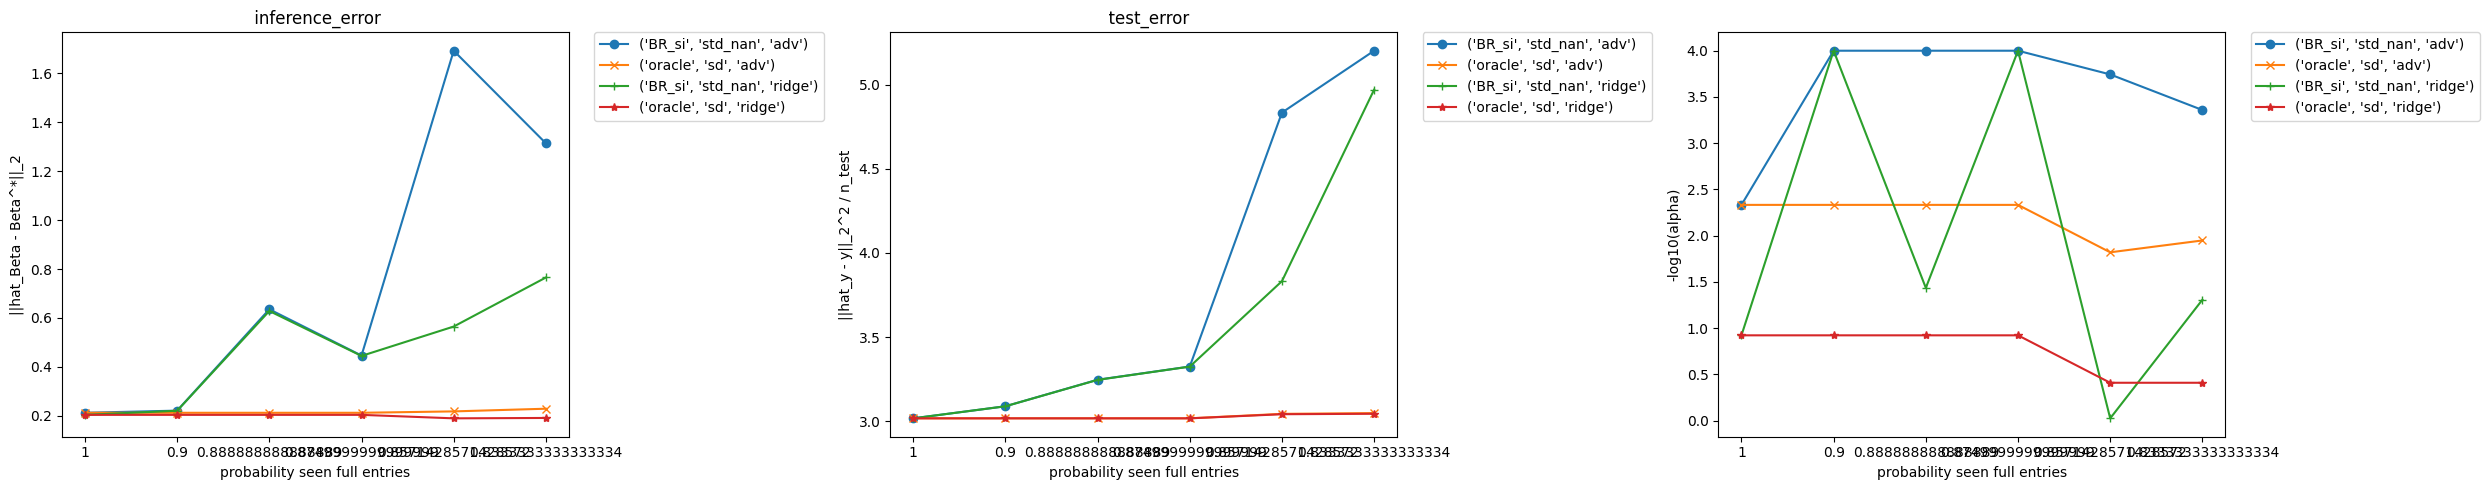

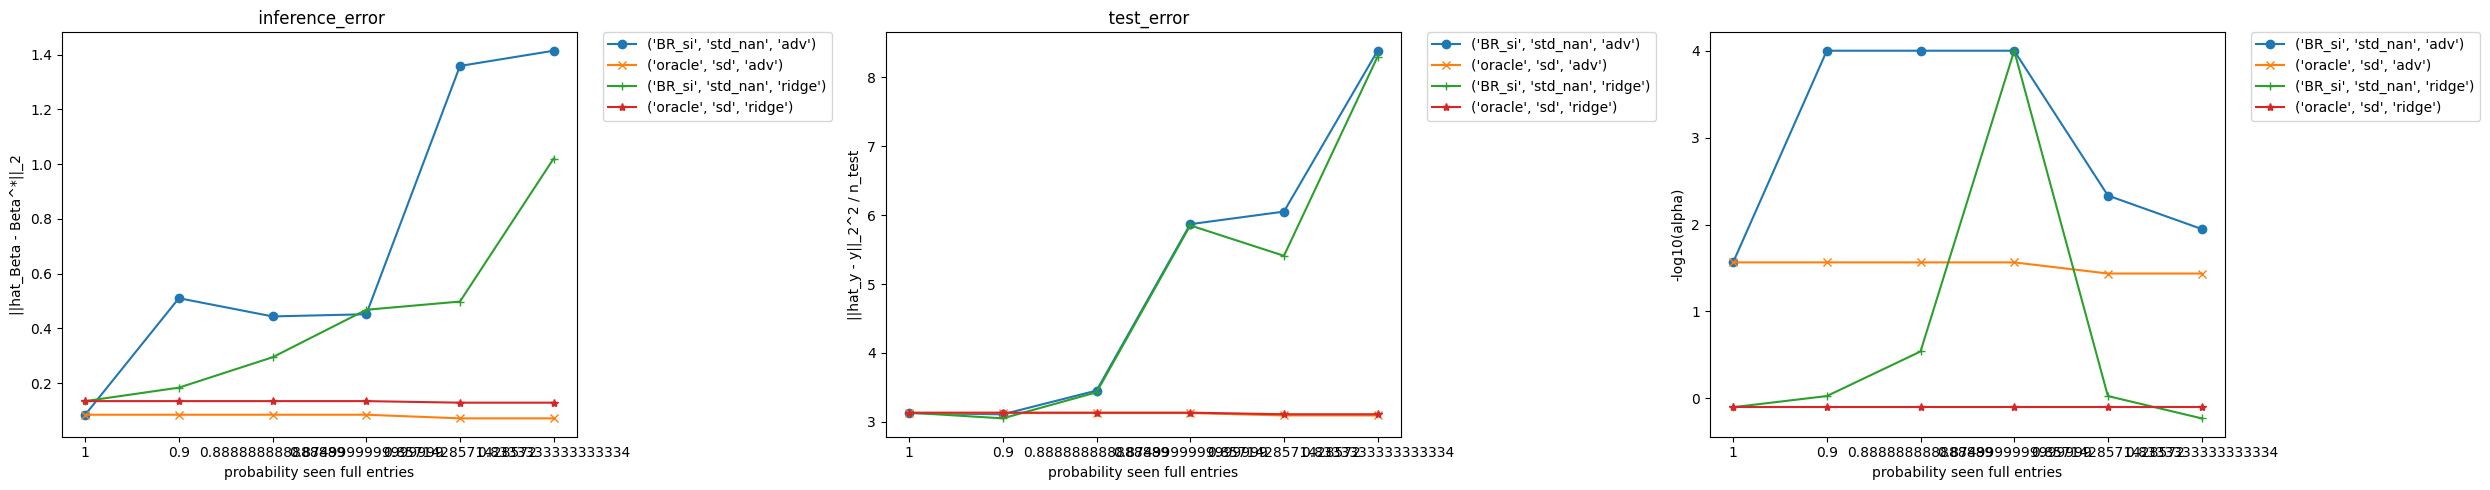

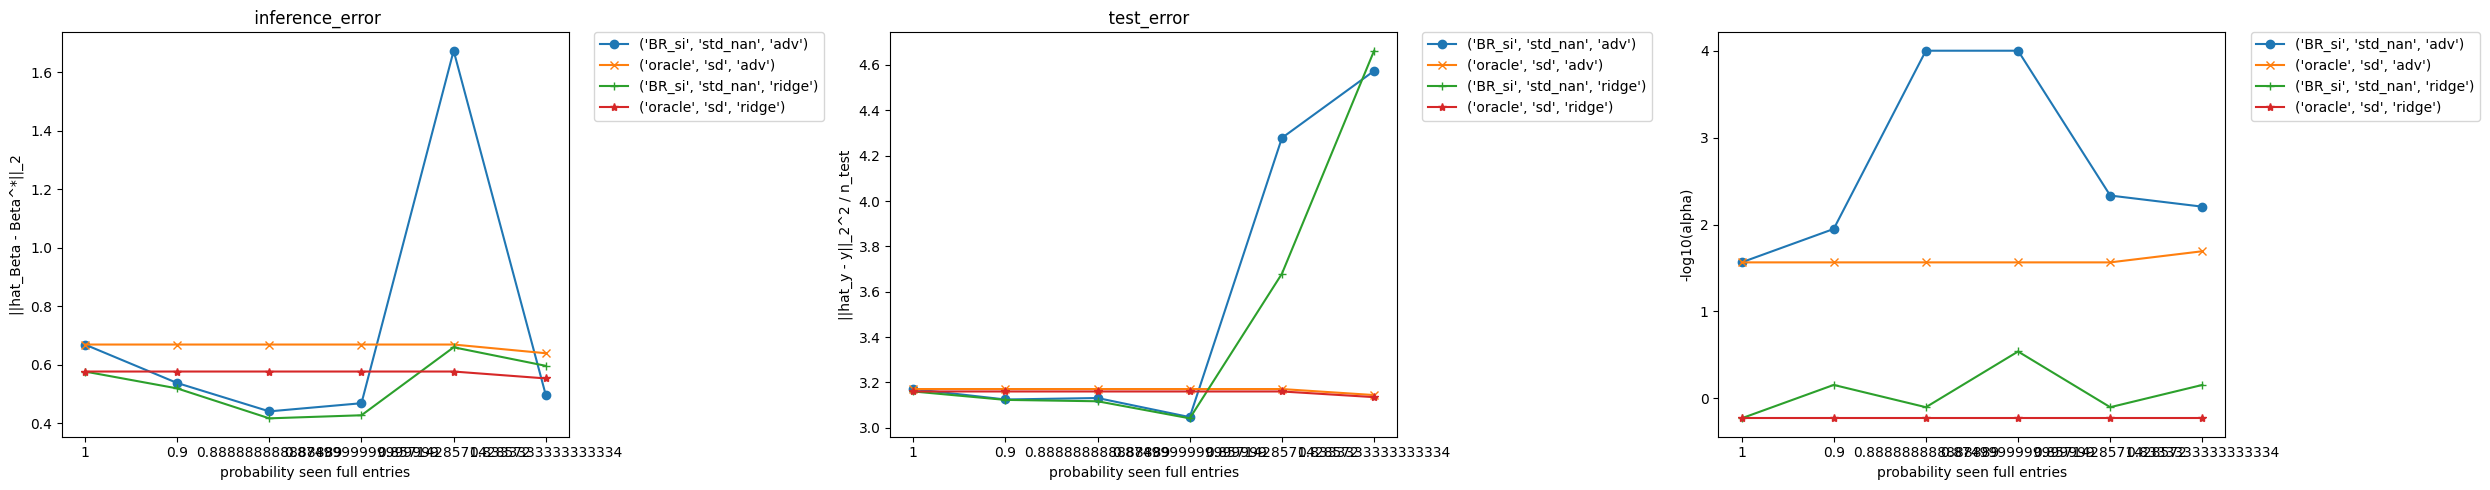

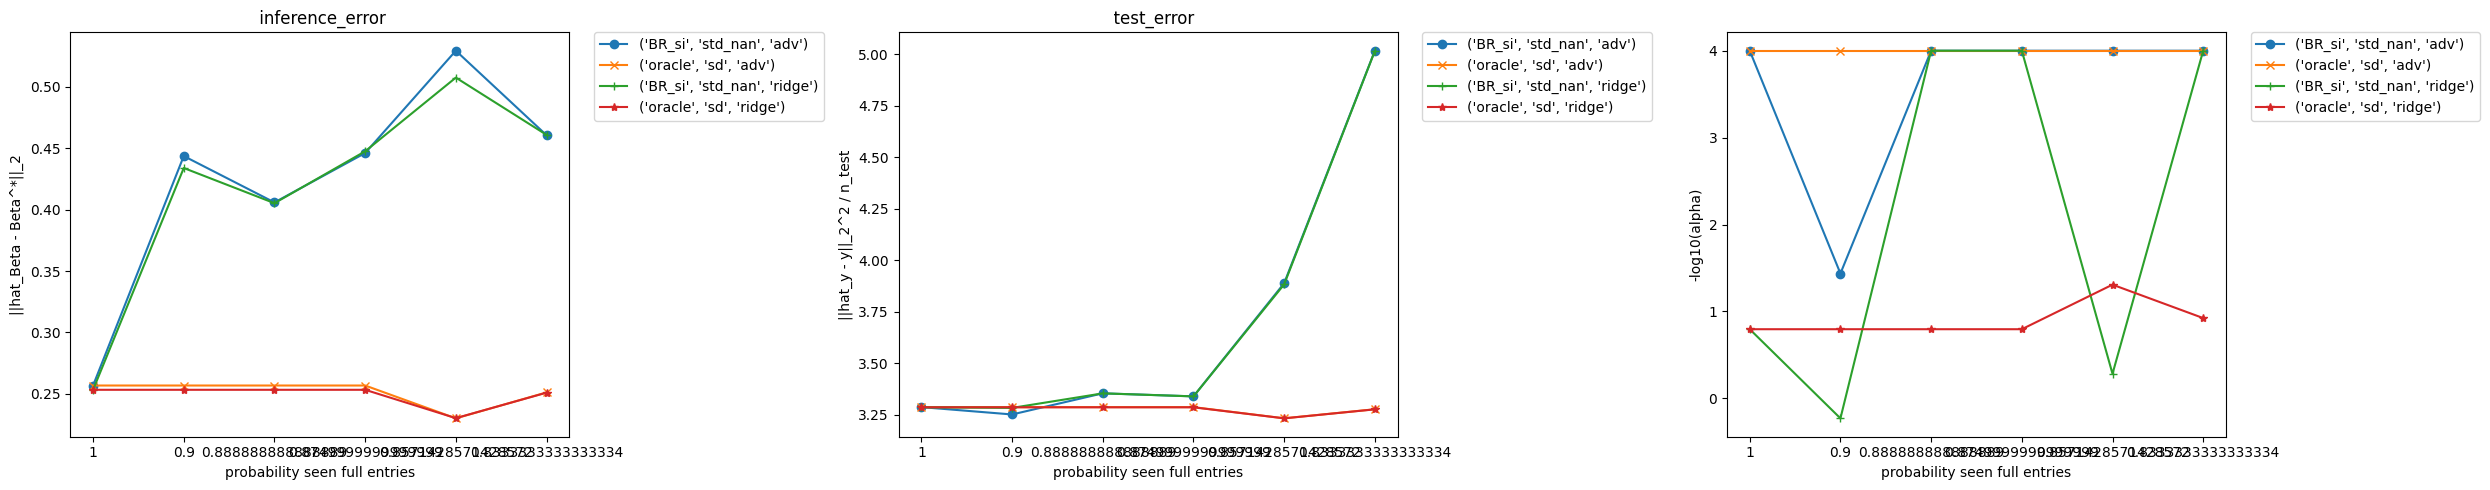

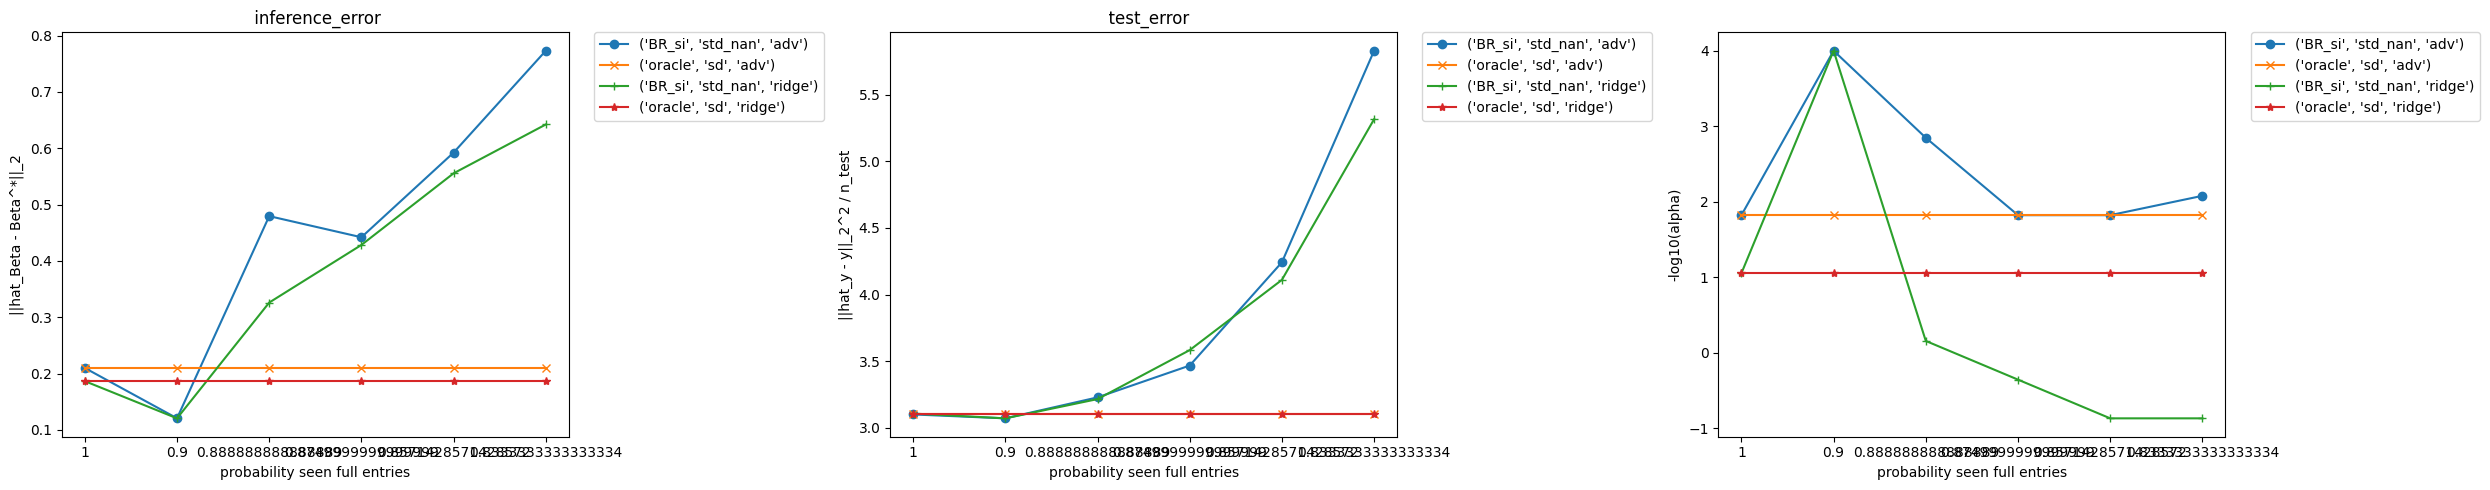

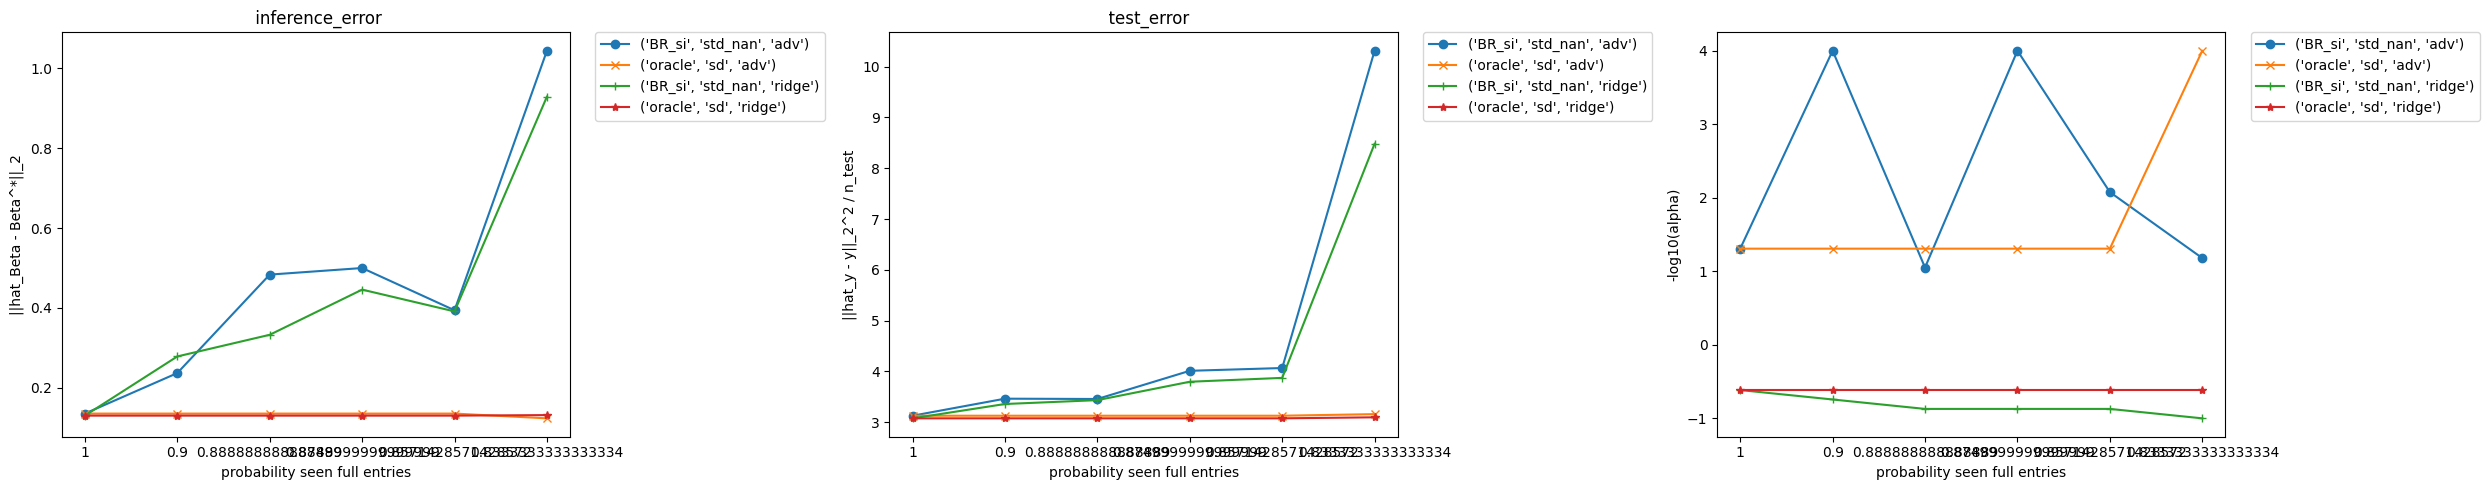

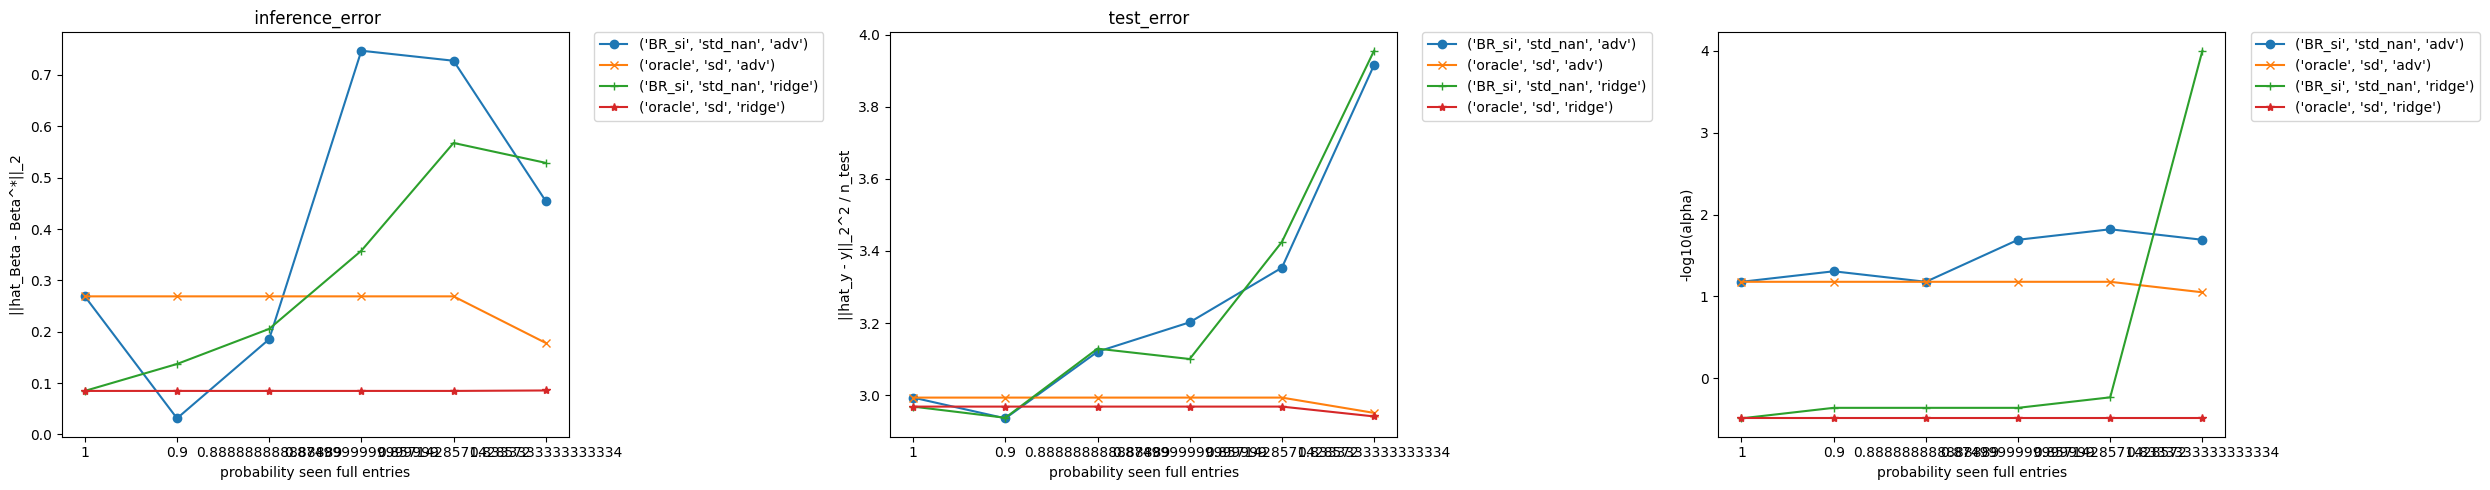

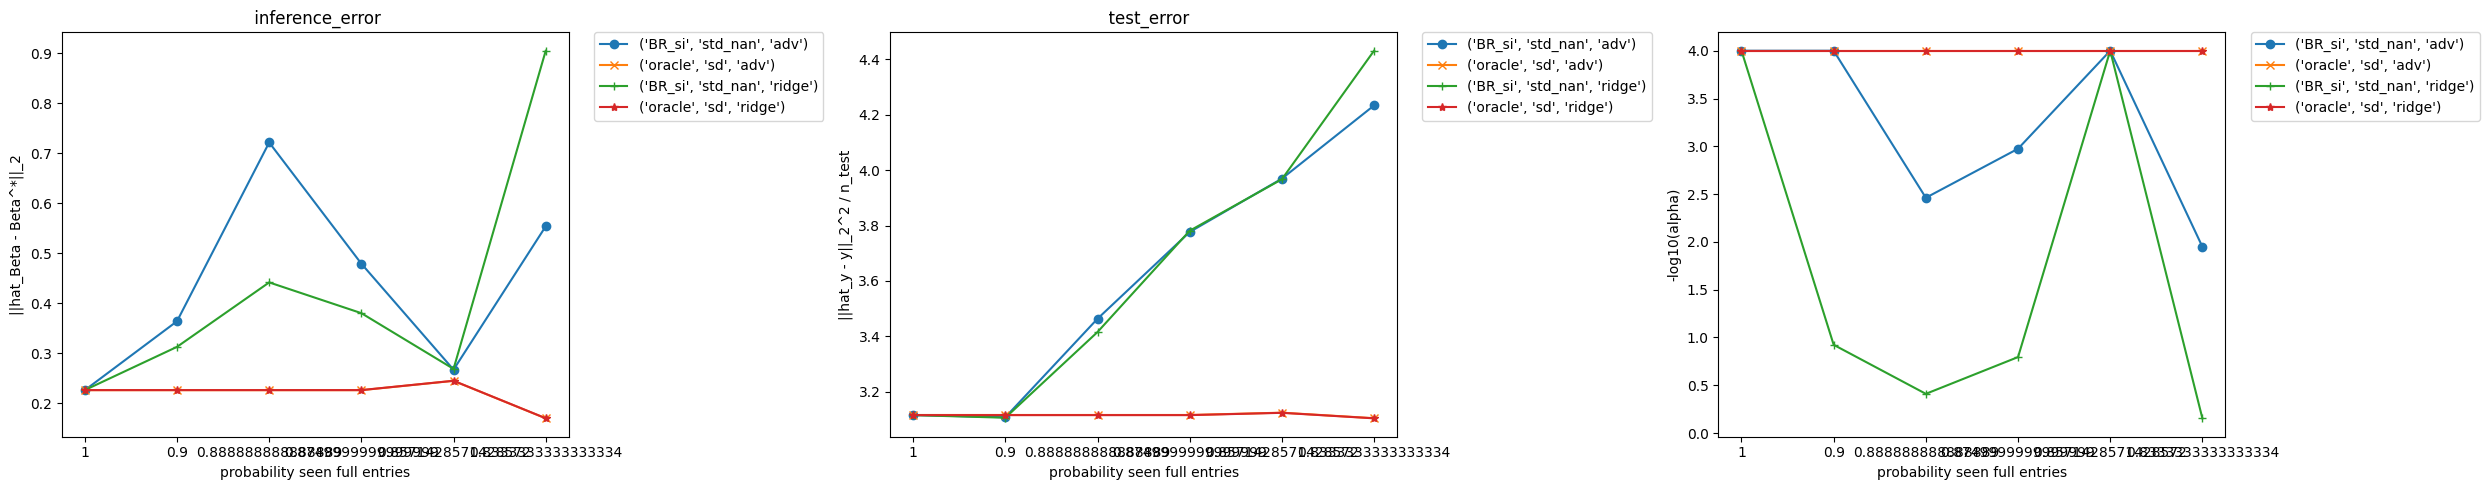

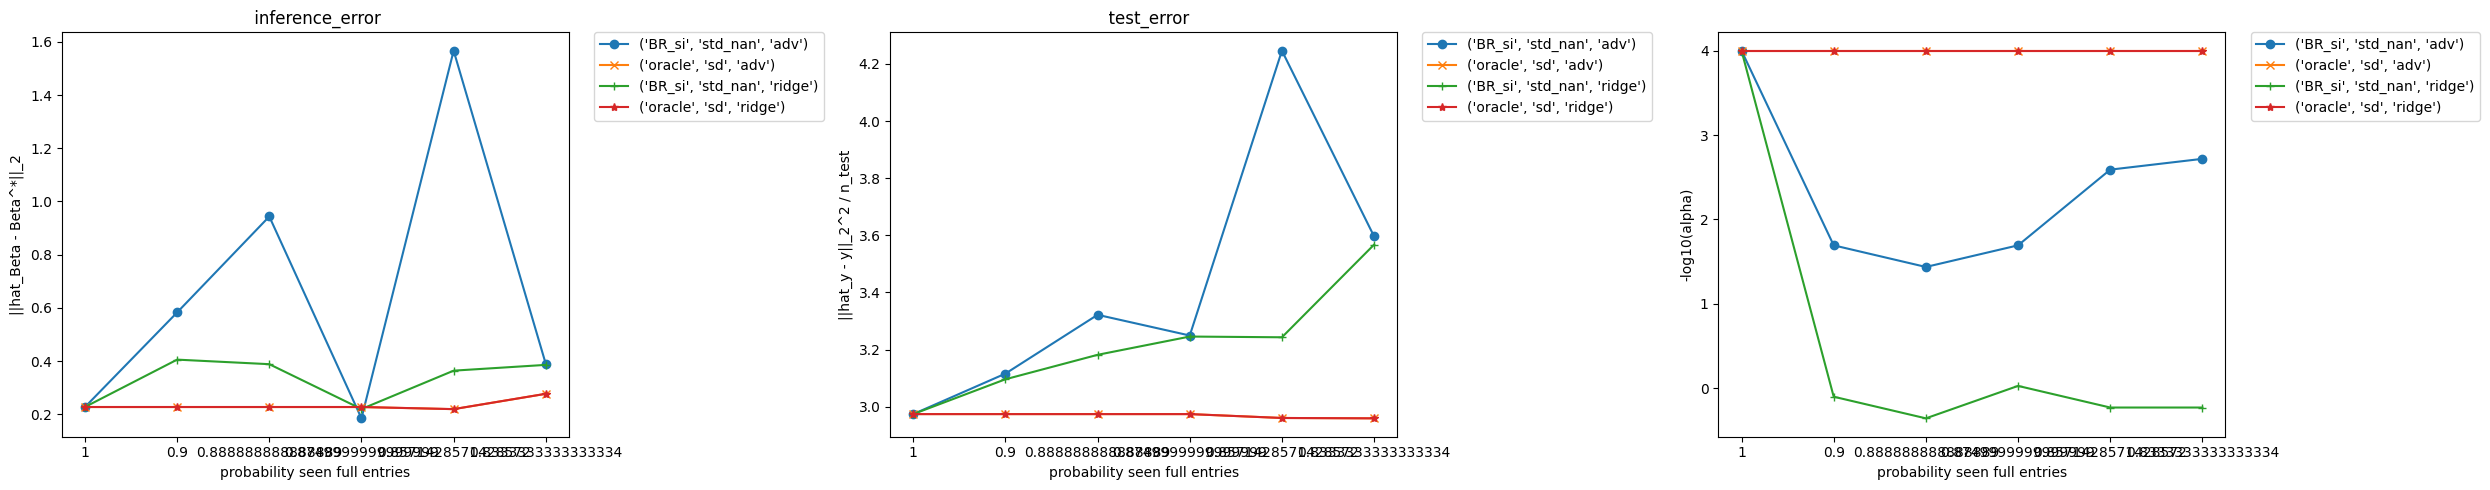

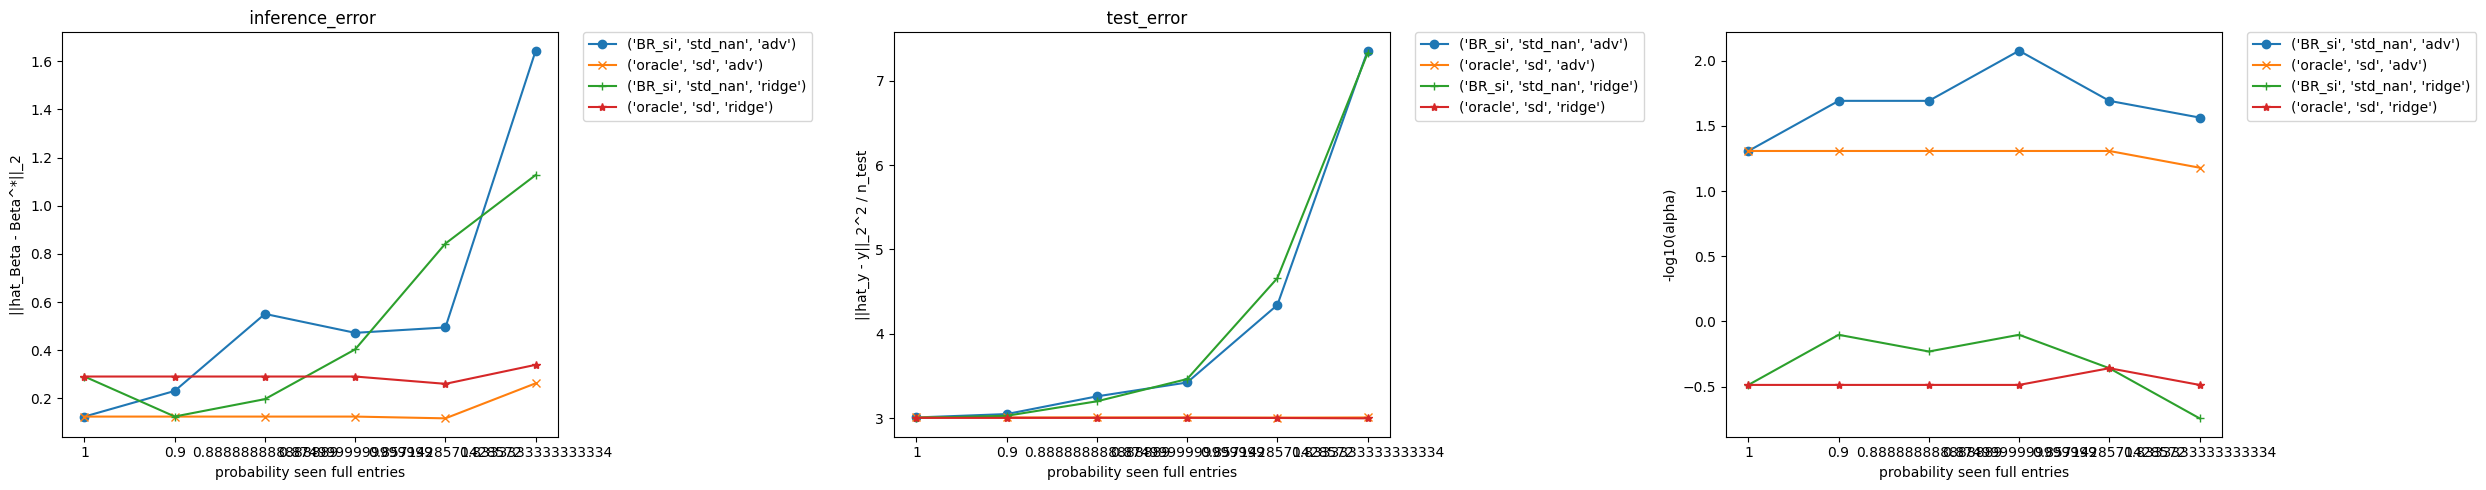

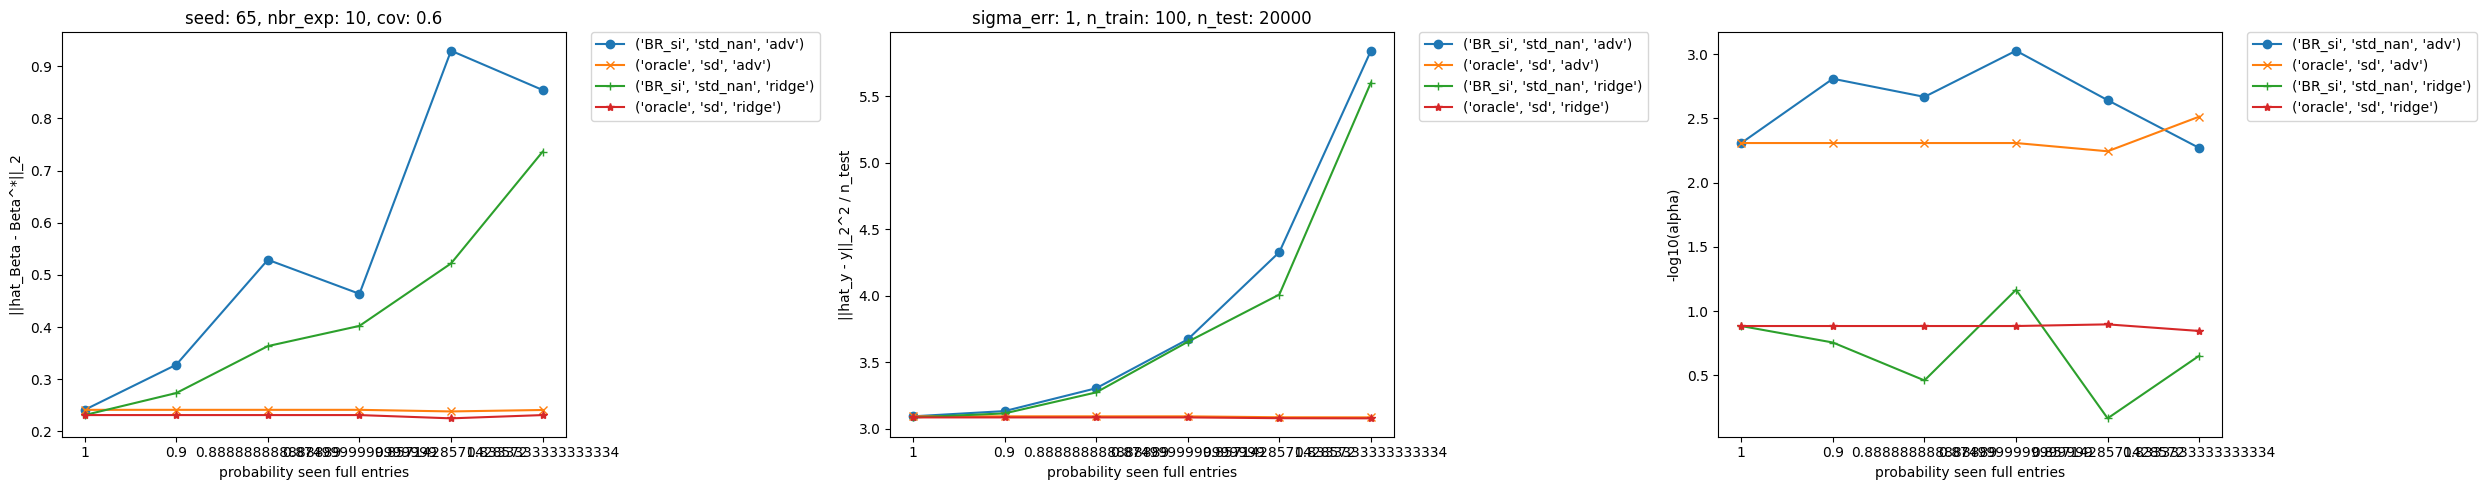

In [22]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [100] * length_vec
error_vec =  [1] * length_vec
#p_seen = make_probabilities(p_seen_both)
p_seen = [p_seen_both] * length_vec
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
cov_var = 0.6
#beta_gt = np.array([-0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4, 5, 6, 7, 8])
#beta_gt = np.array([2, 4, -0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4])
beta_gt = np.random.randn(5)
print(beta_gt)
dim = len(beta_gt)
mean = np.array([0] * dim)
matr = np.random.randn(dim, dim) * 2
cov = matr.T @ matr + np.eye(dim) * 0.1
# np.array([[1, cov_var], [cov_var, 1]])

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': 'Normal', 'mean': mean, 'cov': cov},
    beta_gt = beta_gt,
    p_miss = p_seen,
    err_vector = ['Gaussian_on_X', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc = dicc | {'generation': gen, 'title_infer_error':' inference_error', 'title_test_error':'  test_error'}
dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 10, 'adv_rad_times_delta_mis_max': 10, 'alpha_ridge_reg_max': 10,
                             'eps_adv_rad_times_delta_dts': 1e-5, 'eps_adv_rad_times_delta_mis': 1e-5, 'eps_alpha_ridge_reg': 1e-5,
                             'n_a_dts': 40, 'n_a_mis':5, 'n_a_rid': 40}}

for key, value in dicc.items():
  print(key, ": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 5
# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):

list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn':'adv'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'adv'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv'}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'ridge'}
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}#, 'multip_dataset': 3, 'multip_missing': 3}
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''
nbr_exp = 10
seed = 65
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', n_train: ' + str(n_train[0]) + ', n_test: ' + str(number_test)
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [8]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


[[[4 4]
  [4 2]]

 [[2 4]
  [3 2]]]
[[4 4]
 [4 2]
 [2 4]
 [3 2]]
[[[4 2]
  [4 2]
  [4 2]]]
[[4 2]
 [4 2]
 [4 2]]
[[2 3]
 [2 2]
 [2 2]
 [4 2]
 [3 3]]
[2 3 2 2 2 2 4 2 3 3]
other
[3 3 2 2 2]
[3 3 2 2 2 3 3 2 2 2 3 3 2 2 2]
other mult
[[2 3]
 [4 5]
 [3 3]]
[[2 3]
 [4 5]
 [3 3]
 [2 3]
 [4 5]
 [3 3]
 [2 3]
 [4 5]
 [3 3]]


In [9]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

'\n## random forest imputer\nfrom sklearn.ensemble import RandomForestRegressor\nrf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)\n\nX_rf = single_imputation(X_nan, rf_estimator)\nprint(X_rf.shape)\nsd_rf = np.std(X_rf, axis=0)\nS_inv_rf = np.diag(1 / sd_rf)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std rf\n ", sd_rf)\nfig, ax = plt.subplots(num=\'advtrain_linf_rf\')\nlinfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)\nestimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_rf, ax)\n'

In [10]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

'\n## iterative imputer Bayesian Ridge\n\nfrom sklearn.linear_model import BayesianRidge\nbr_estimator = BayesianRidge()\n\nX_br = single_imputation(X_nan, br_estimator)\nsd_br = np.std(X_br, axis=0)\nS_inv_br = np.diag(1 / sd_br)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std  br\n ", sd_br)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_br\')\nlinfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)\nestimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)\nplot_coefs_l1norm(coefs_advtrain_linf_br, ax)\n'

In [11]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

"\n## mean imputation\nfrom sklearn.impute import SimpleImputer\n\nimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')\nX_mean = imp_mean.fit_transform(X_nan)\nsd_mean = np.std(X_mean, axis=0)\nprint(sd_mean)\nS_inv_mean = np.diag(1 / sd_mean)\n\nfig, ax = plt.subplots(num='advtrain_linf_mean')\nlinfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)\nestimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_mean, ax)\n"

In [12]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

'\n# imputation elliptic\n\nmu = np.nanmean(X_nan, axis=0)\nprint("means ", mu)\ndelta = np.mean(masks) # parameter missingness\nprint("delta ", delta)\nX_0 = np.nan_to_num(X_nan)\nprint("nbr obs", X_0.shape[0])\nS_ellp =  X_0.T @ X_0 / X_0.shape[0]\nS_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp\nprint("eig cov ", np.linalg.eigvalsh(S_ellp))\nX_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)\n#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance\nsd_inv_ellp = np.std(X_ellp, axis=0)\nprint("sd ellp", sd_inv_ellp)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_ellp\')\nlinfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)\nestimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)\n'

TypeError: add_rectangles() takes 4 positional arguments but 5 were given

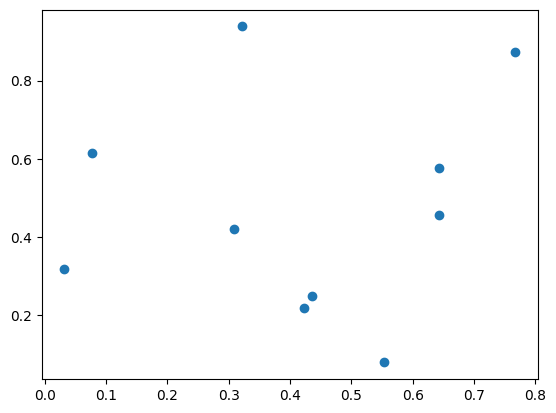

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



In [ ]:
import numpy as np

XX = np.random.randint(1, 7, (2, 3, 3))
print(XX)
XXX = np.tile(XX, (2, 1, 1))
print(XXX)

print(np.zeros(2))

y_o = np.array([1, 2])
y_oo = np.tile(y_o, 3)
print(y_oo)


In [ ]:
import numpy as np
def generate_masks_binomial_general(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks


#mm = np.random.binomial(1, [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]], (2, 3, 3))
#print(mm)
cc = np.array([np.random.binomial(1, x, (4, 4)) for x in [0.2, 0.2, 0.2]])
print(cc)
s_cc = np.cumsum(cc, axis=0)
print(s_cc)
s_cc[s_cc>1] = 1
print(s_cc)

s_v = np.random.randint(1, 4, (3, 4))
print(s_v)
s_vv = s_v[:, None, :] * np.eye(4)
print(s_vv)









In [ ]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import ridge_regression

X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)
np.random.seed(4)
alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False, random_state=0)
for a in alphas:
  #coef, intercept = estim(X, y, a)
  coef = estim(X, y, a)
  print("coef : ", coef)
  #print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  #print("coef : ", coef)
  #print("intercpt ", intercept)




